### **Importing Required Modules**
- ```numpy``` & ```pandas``` Used for numerical computations and data manipulation.
- `h5py`: Handles HDF5 file formats for storing large datasets.
- `pickle`: Serializes and deserializes Python objects.
-  ```torch``` for defining, training, and optimizing neural networks.
- ```matplotlib```Used for plotting graphs and visualizing data trends.
- `os`: Provides system-related functions like file handling.
- `time`: Used for performance measurement and timing execution.



In [1]:
import numpy as np
from collections import defaultdict
import h5py
import pickle
from matplotlib import pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import h5py
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader, TensorDataset
import os, time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

### **Dataset Path**

In [2]:
dataset_path = "/kaggle/input/radioml-2025/GOLD_XYZ_OSC_POSITIVE_COMBINED_NEW.hdf5"

## **Loading Dataset from HDF5 File**
- Opens an HDF5 file in read mode.
- Extracts X (IQ samples), Y (class indices), and Z (SNR values) from the dataset.

In [3]:
with h5py.File(dataset_path, 'r') as file:
        X = file['X'][:]  # IQ samples
        Y = file['Y'][:]  # Class indices (already mapped to contiguous indices)
        Z = file['Z'][:]  # SNR values

In [4]:
print(X.shape, Y.shape, Z.shape)

(866320, 1024, 2) (866320,) (866320,)


## **Constellation Diagram**
- A constellation diagram is a representation of a signal modulated by a digital modulation scheme.
- It shows the signal as a point in the complex plane at symbol sampling instants.
- The plot is generated using the IQ samples from the dataset.

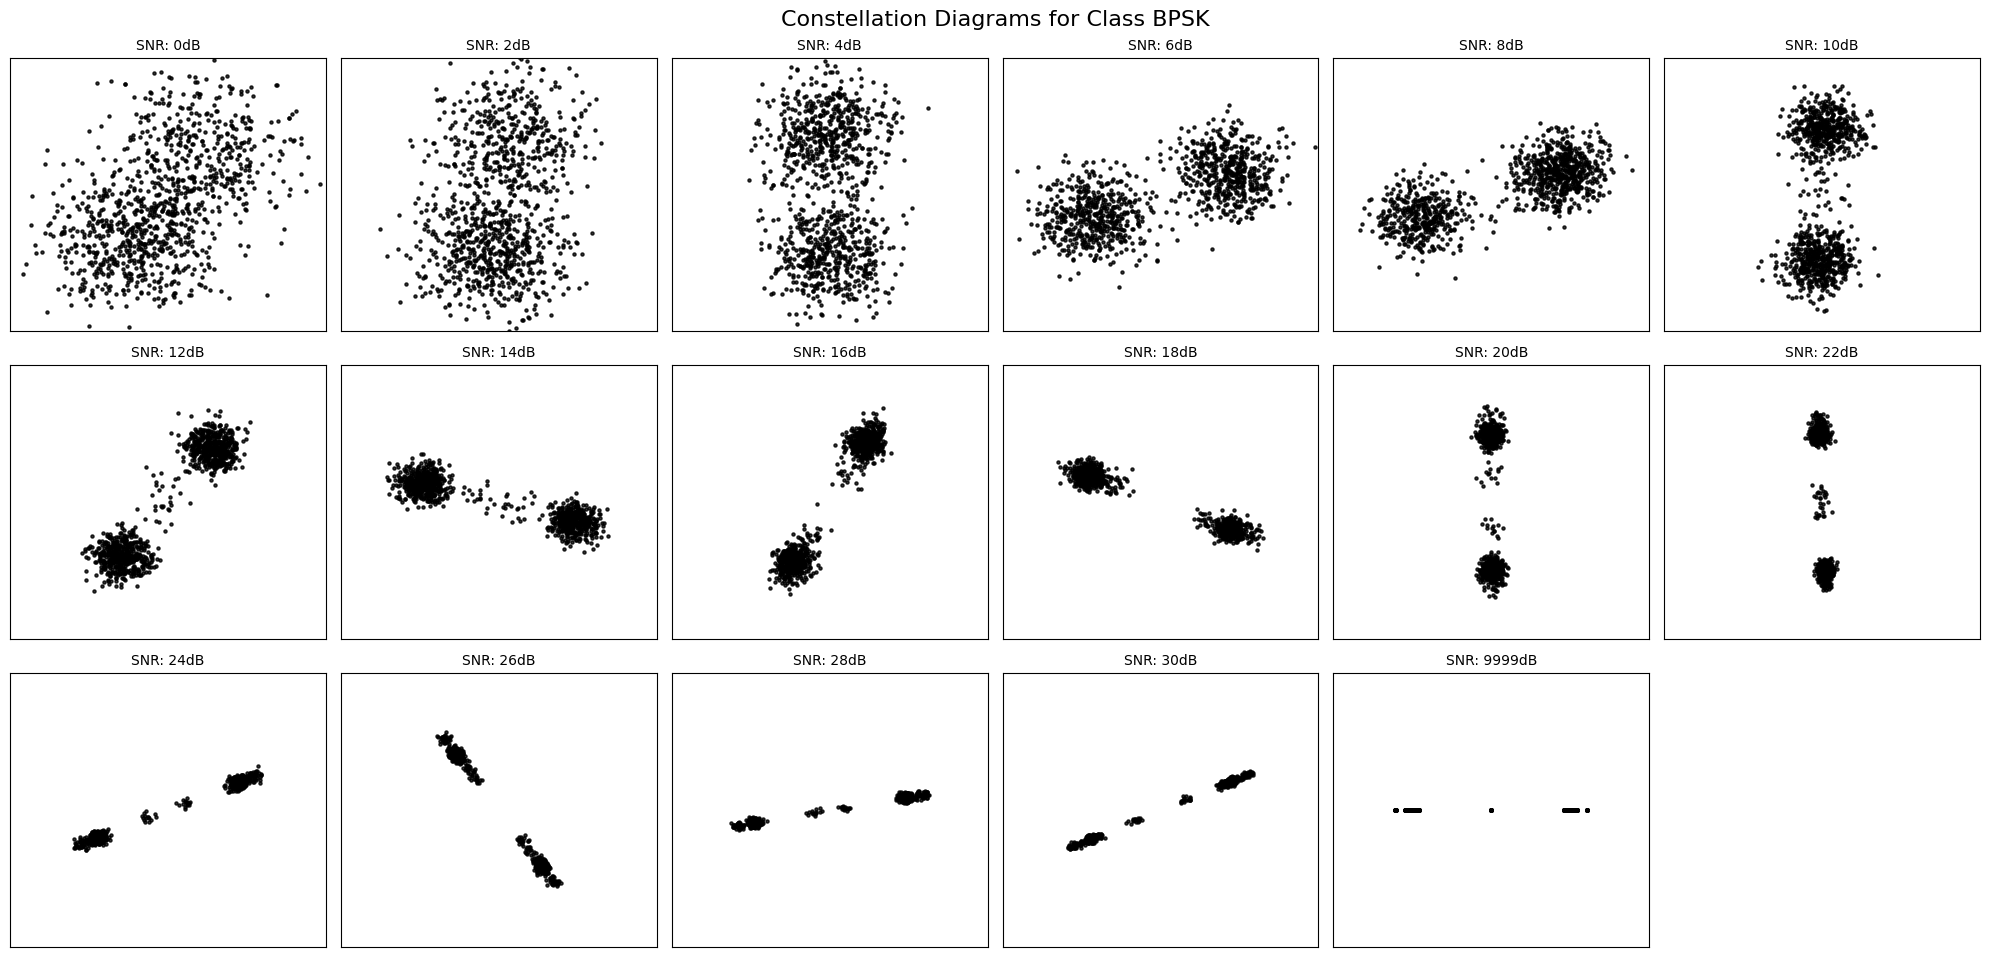

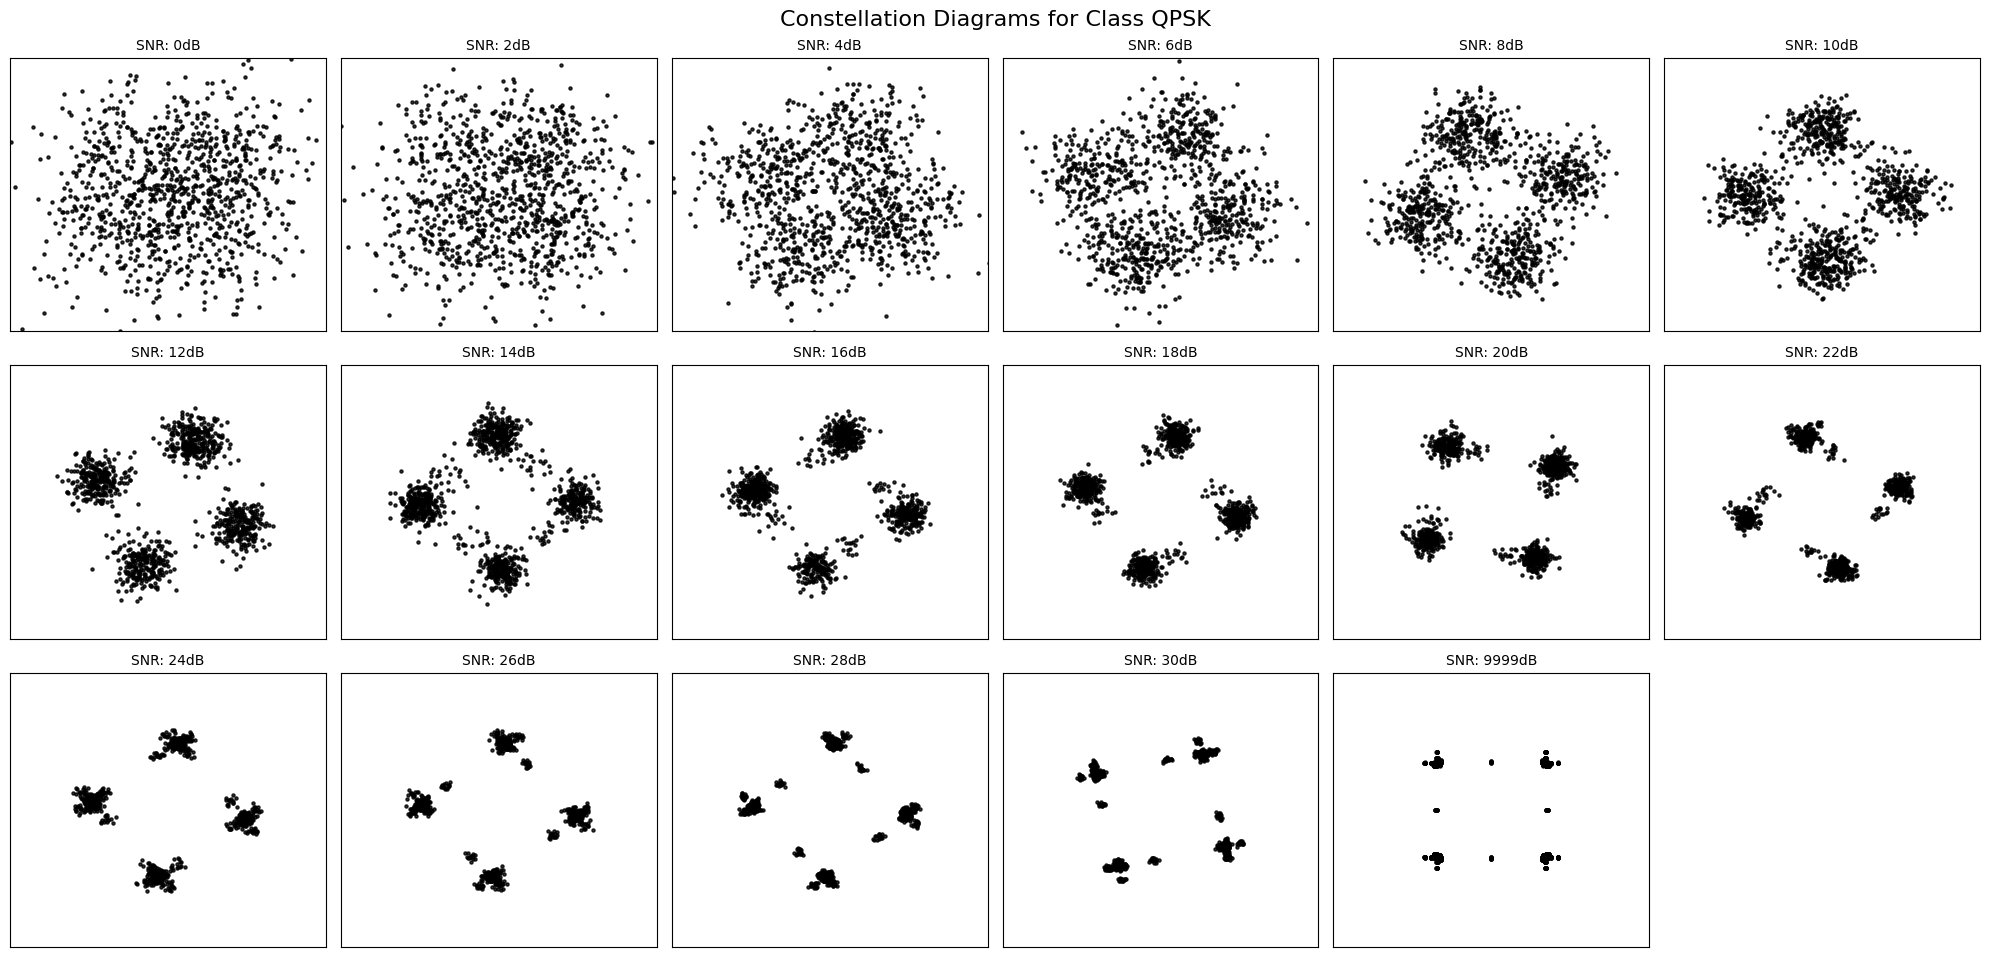

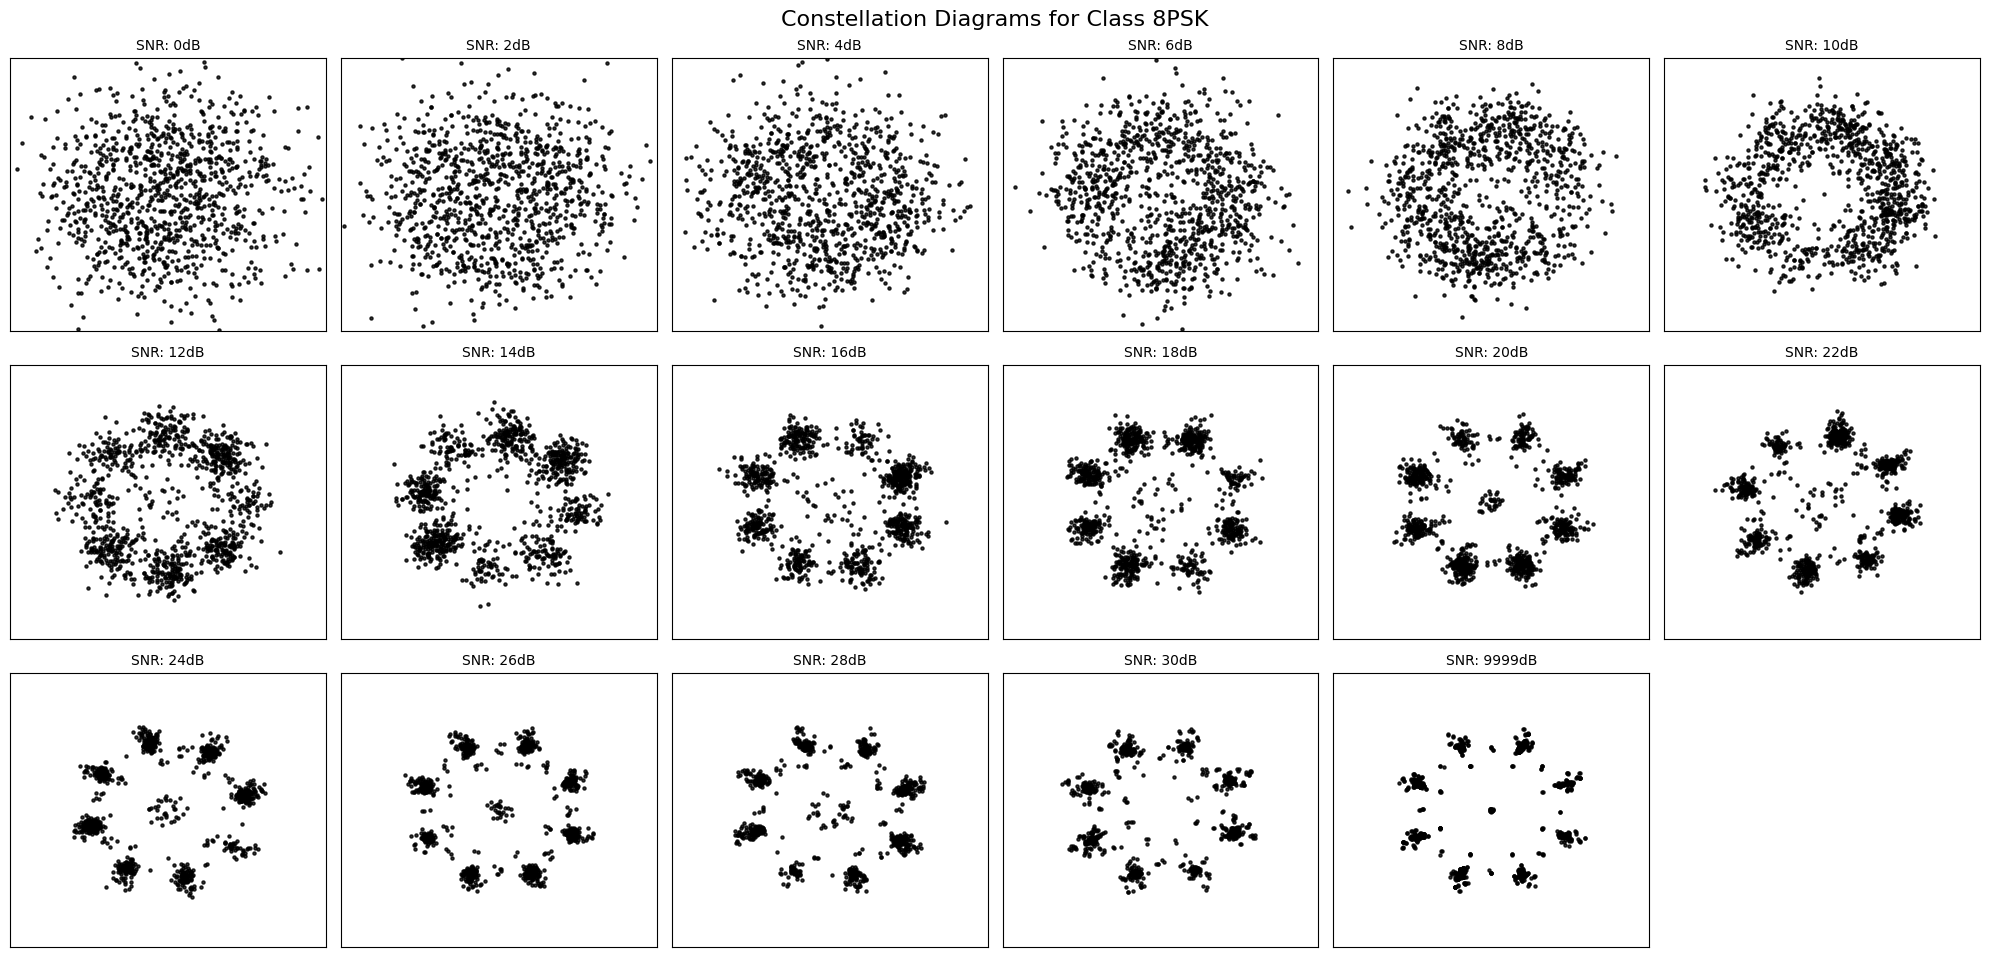

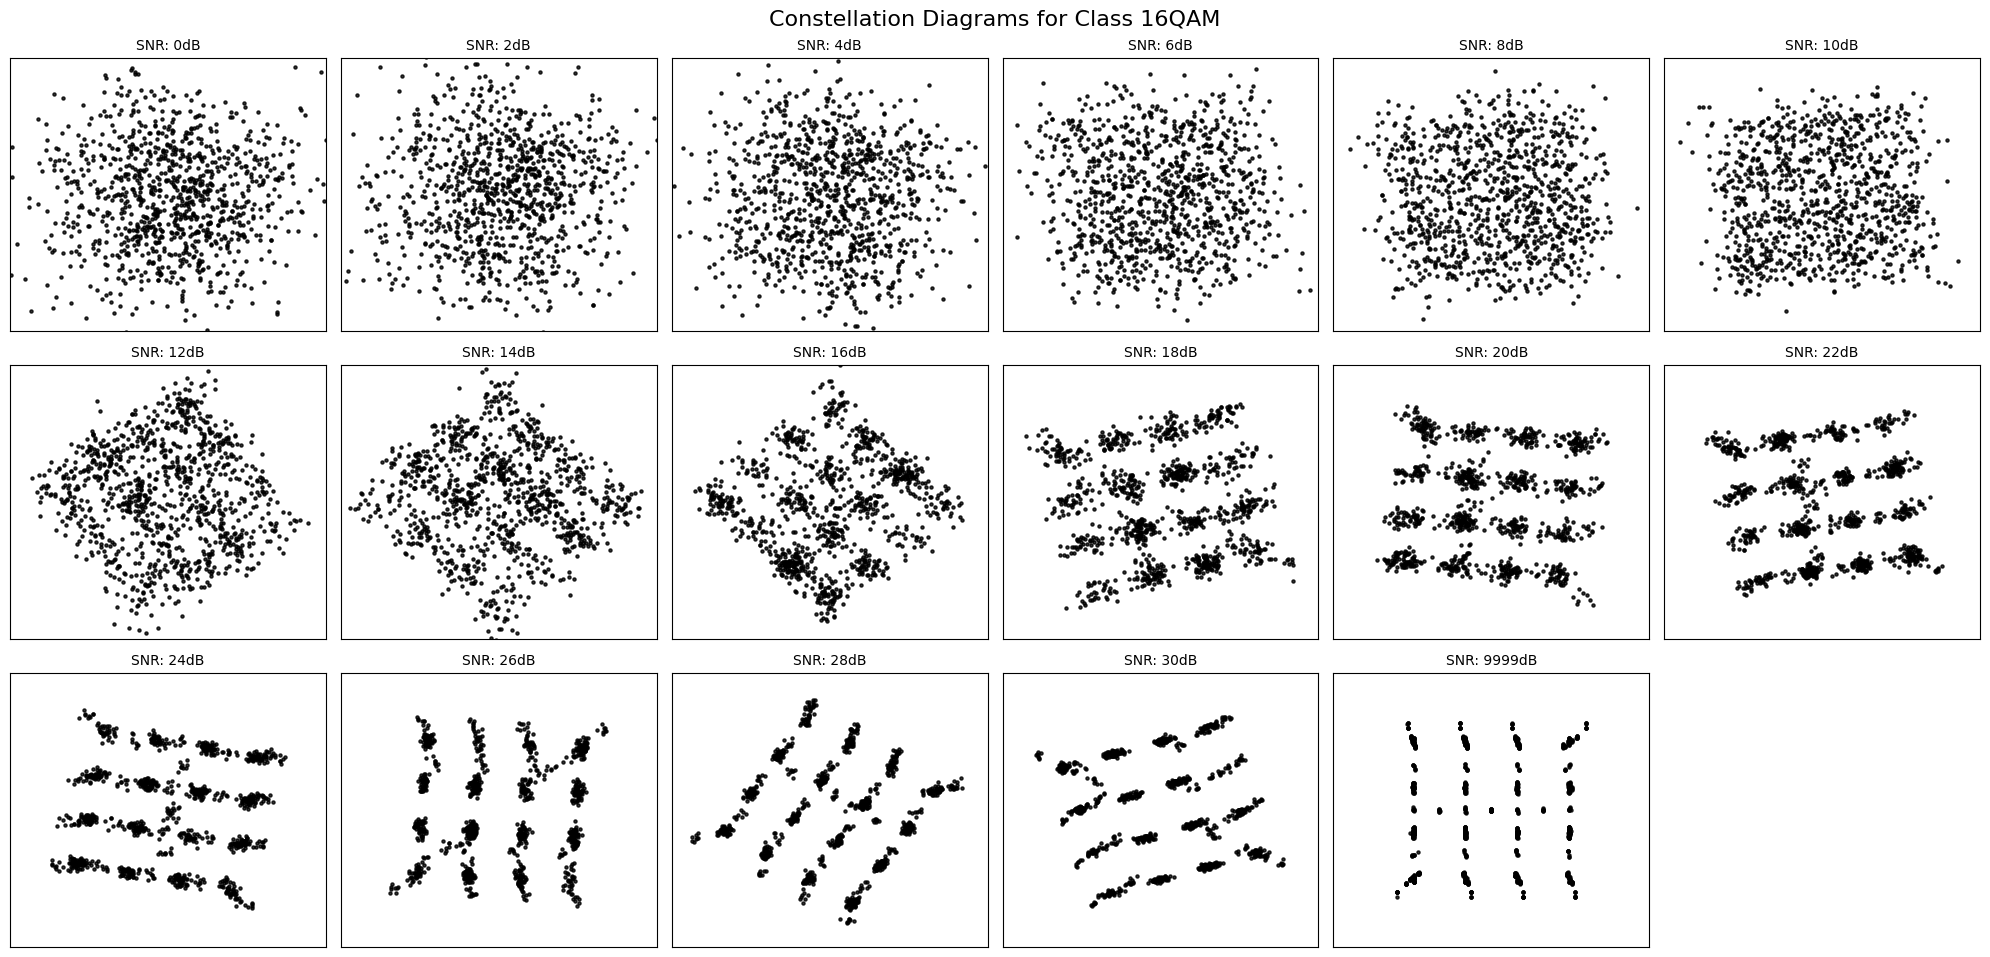

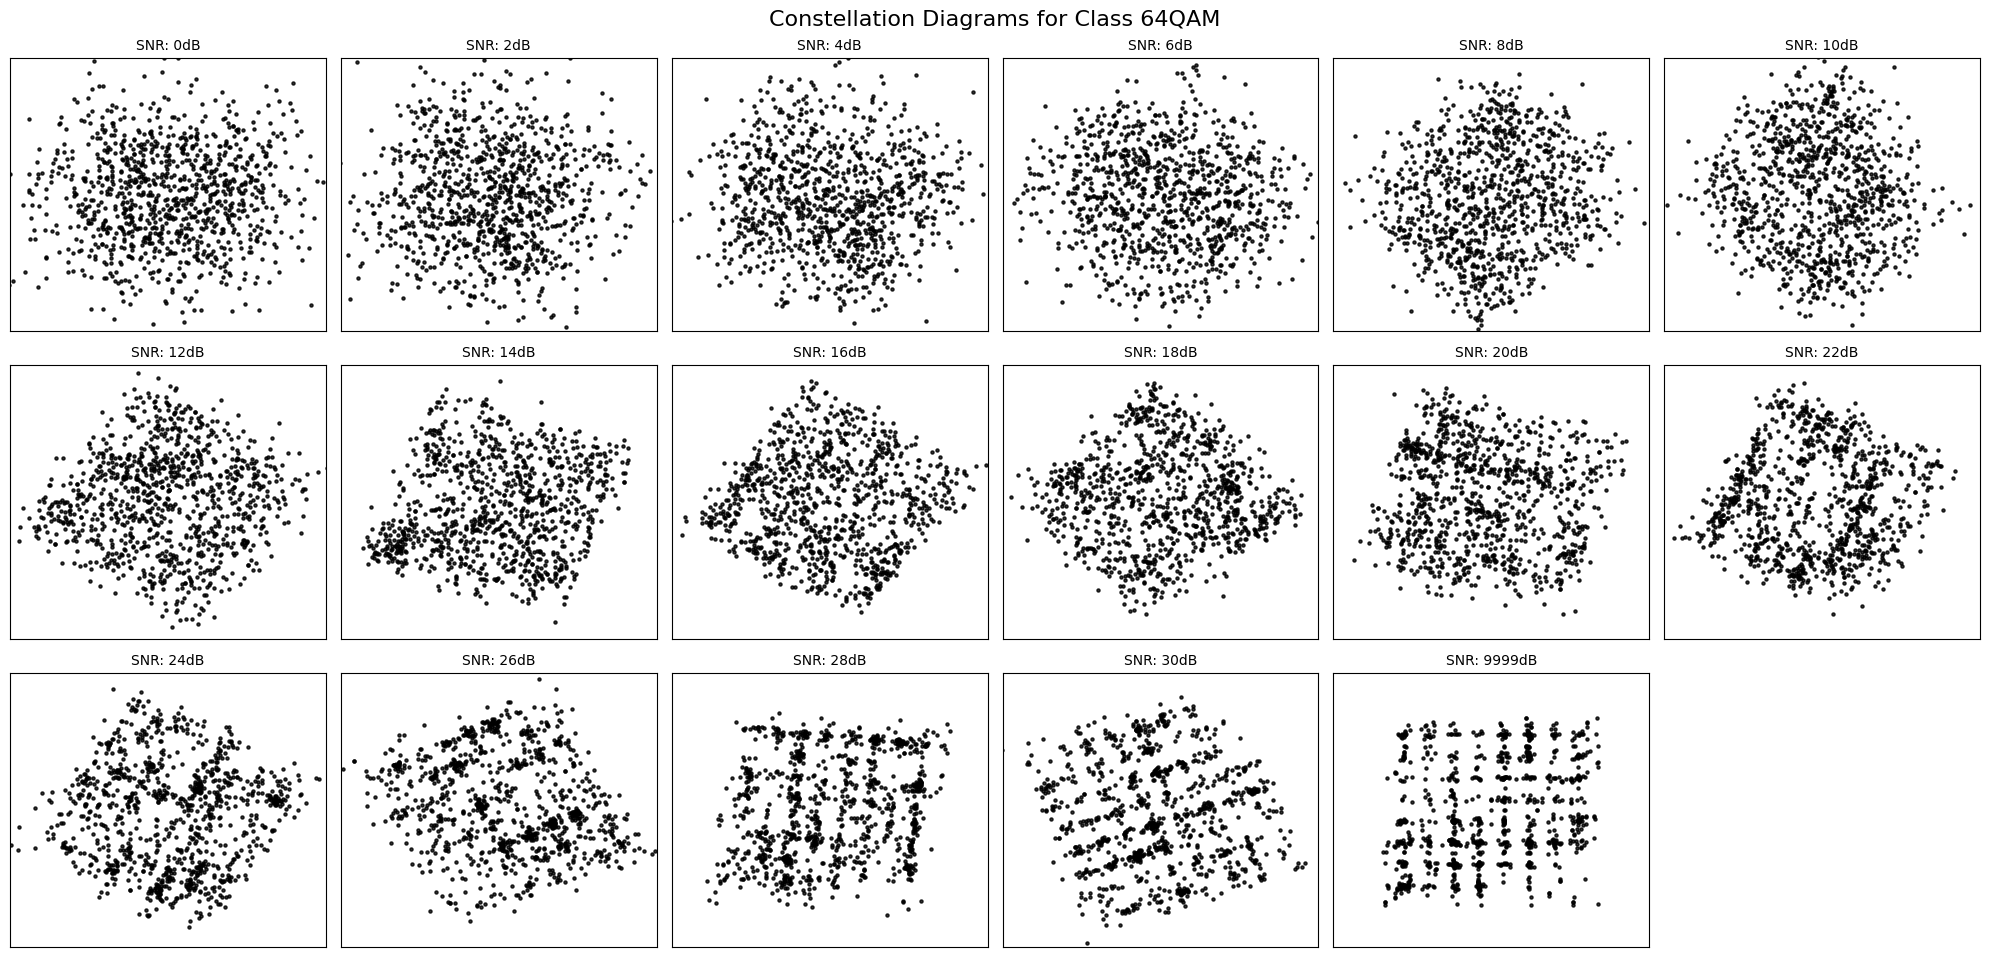

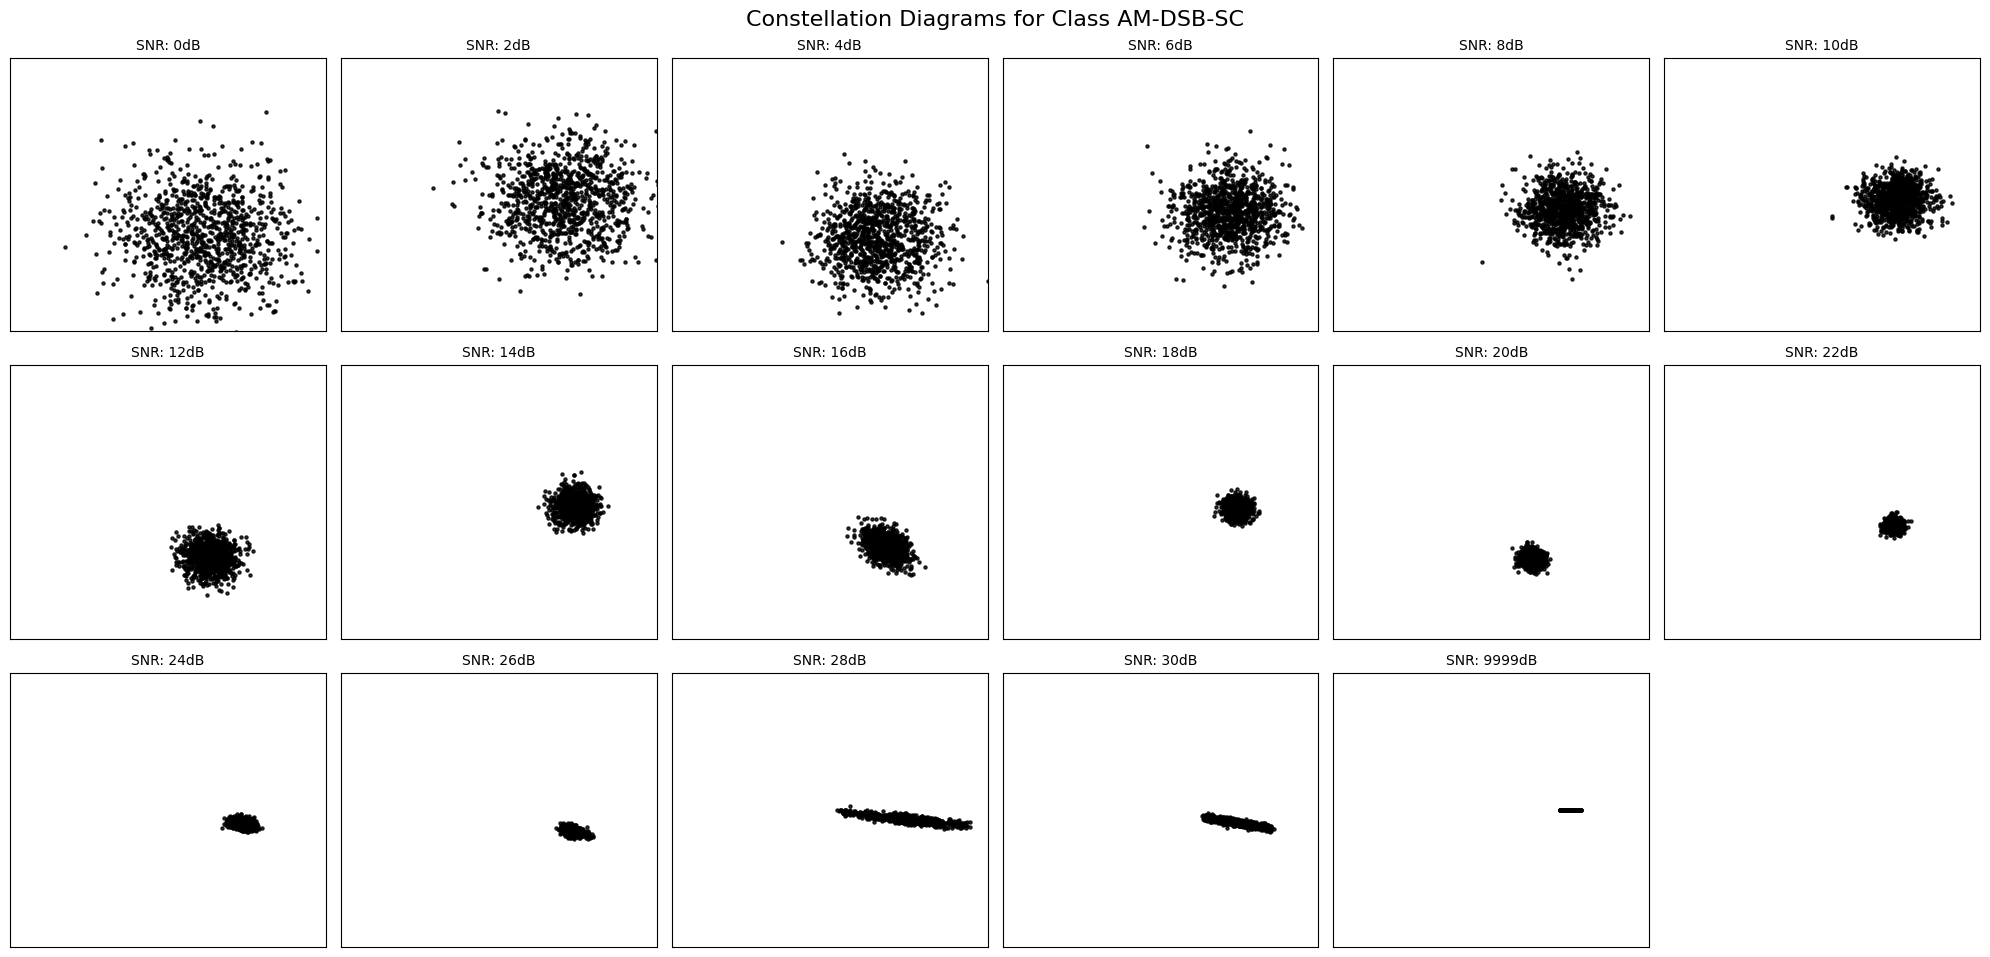

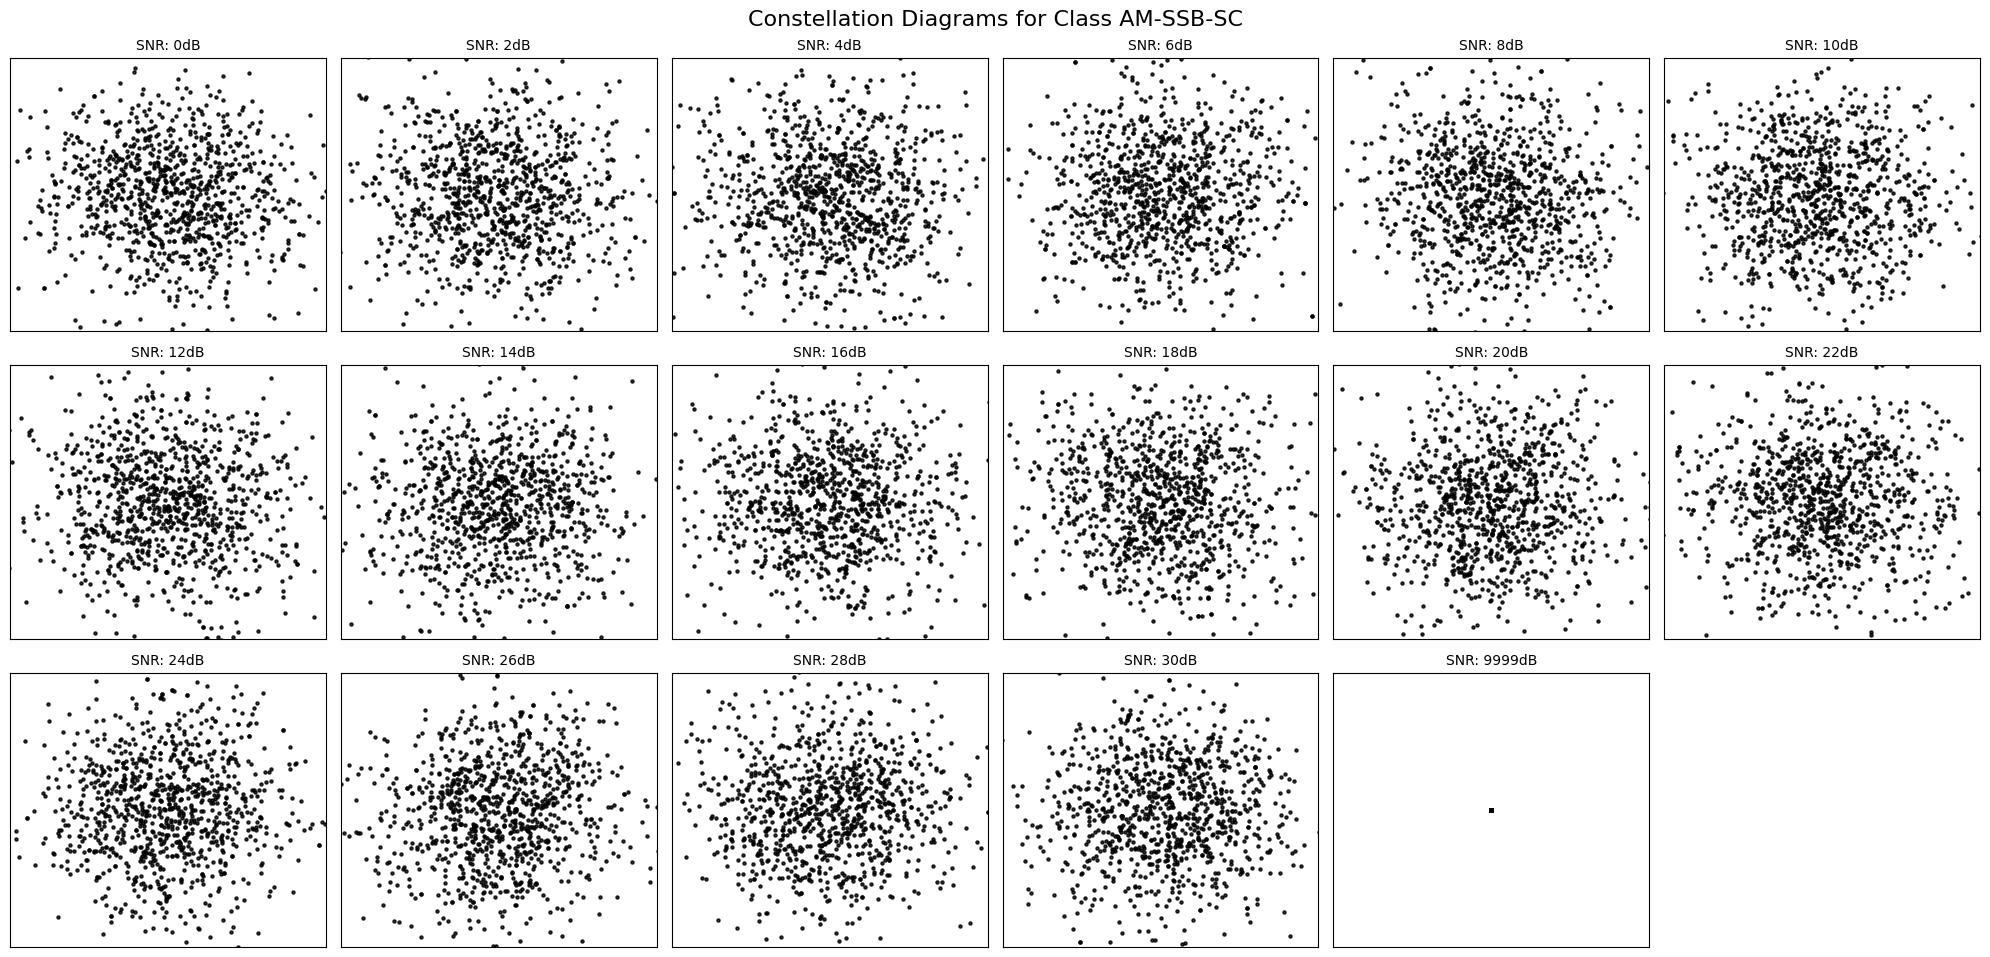

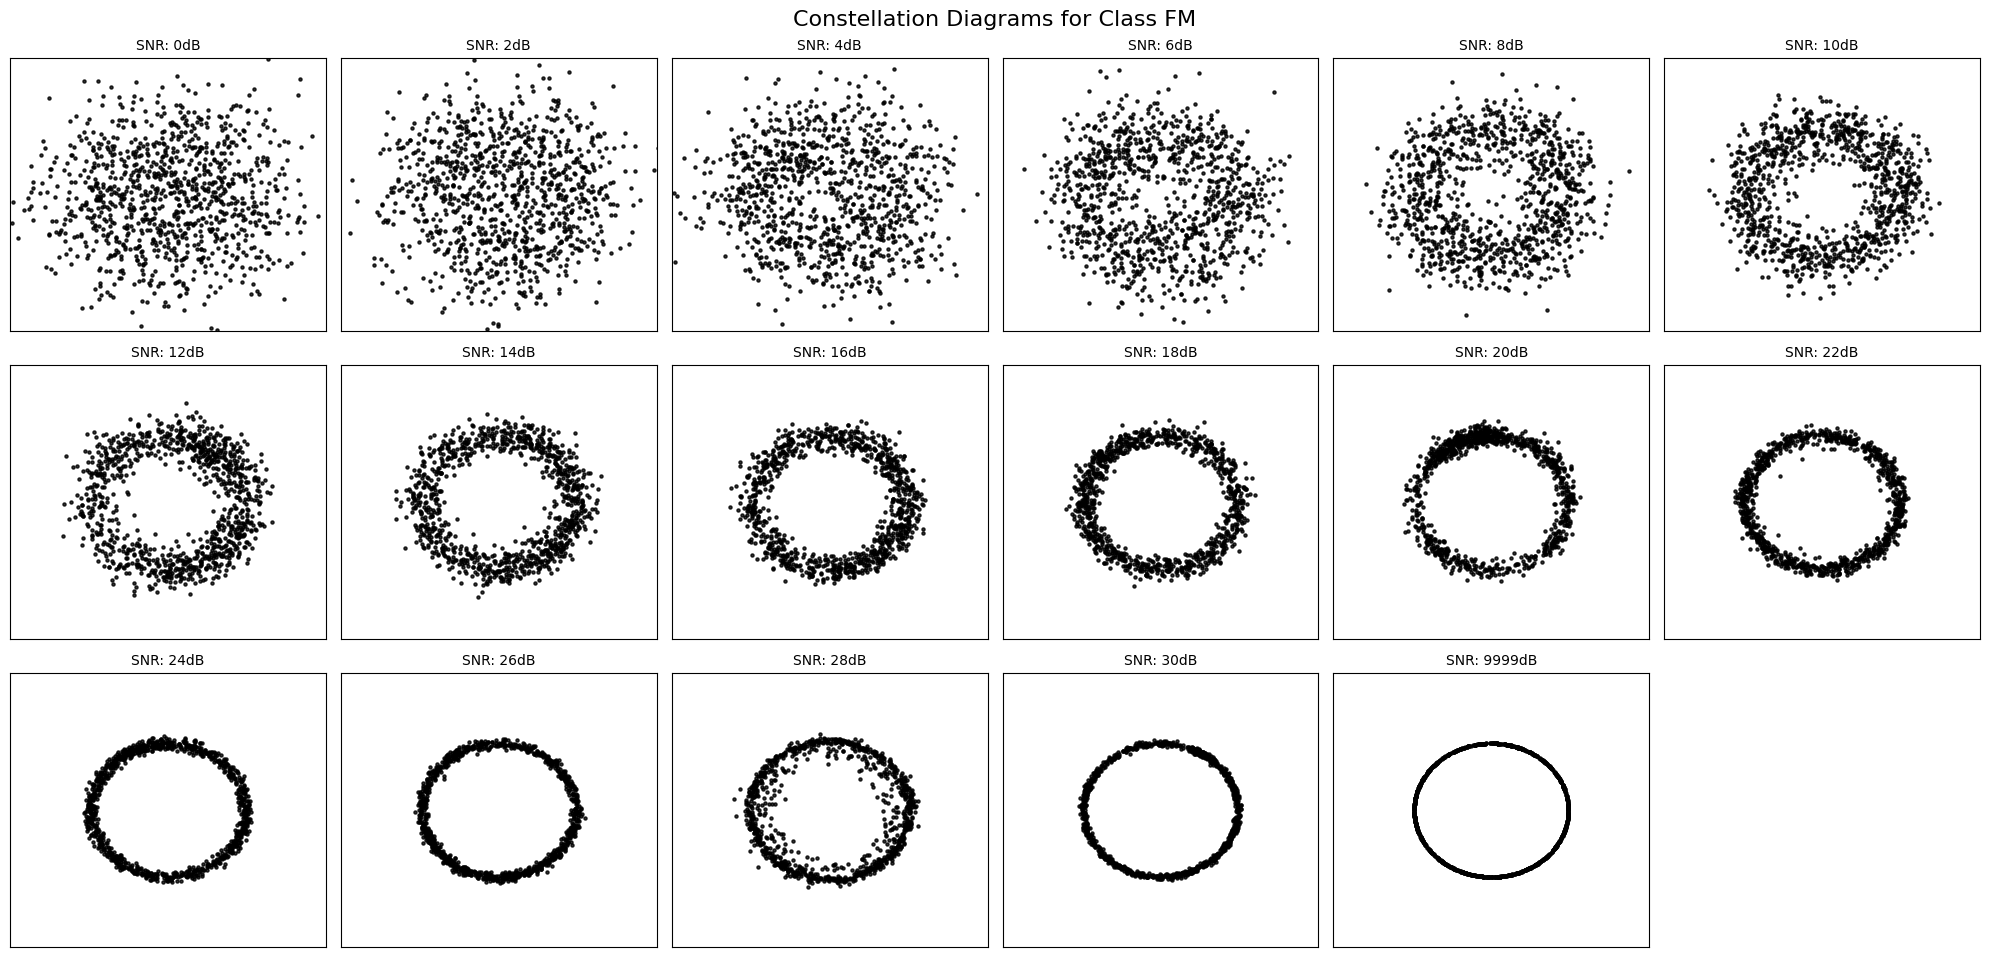

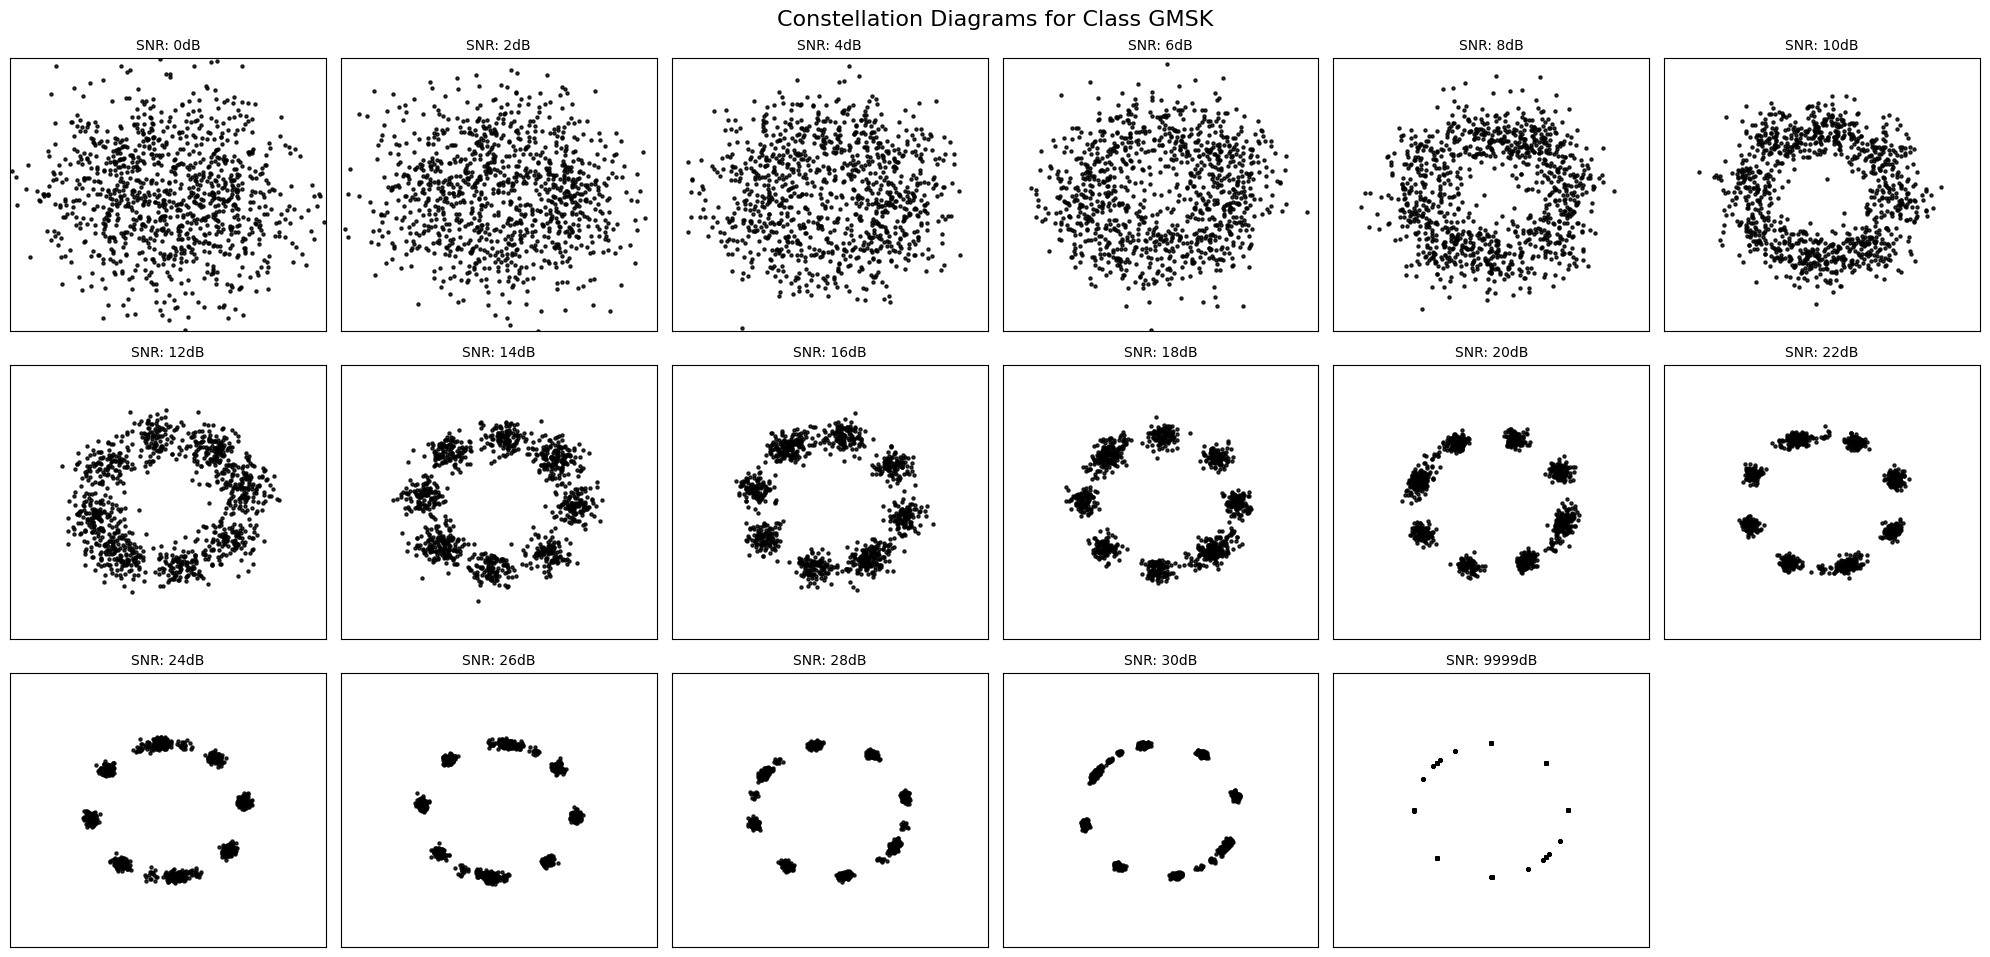

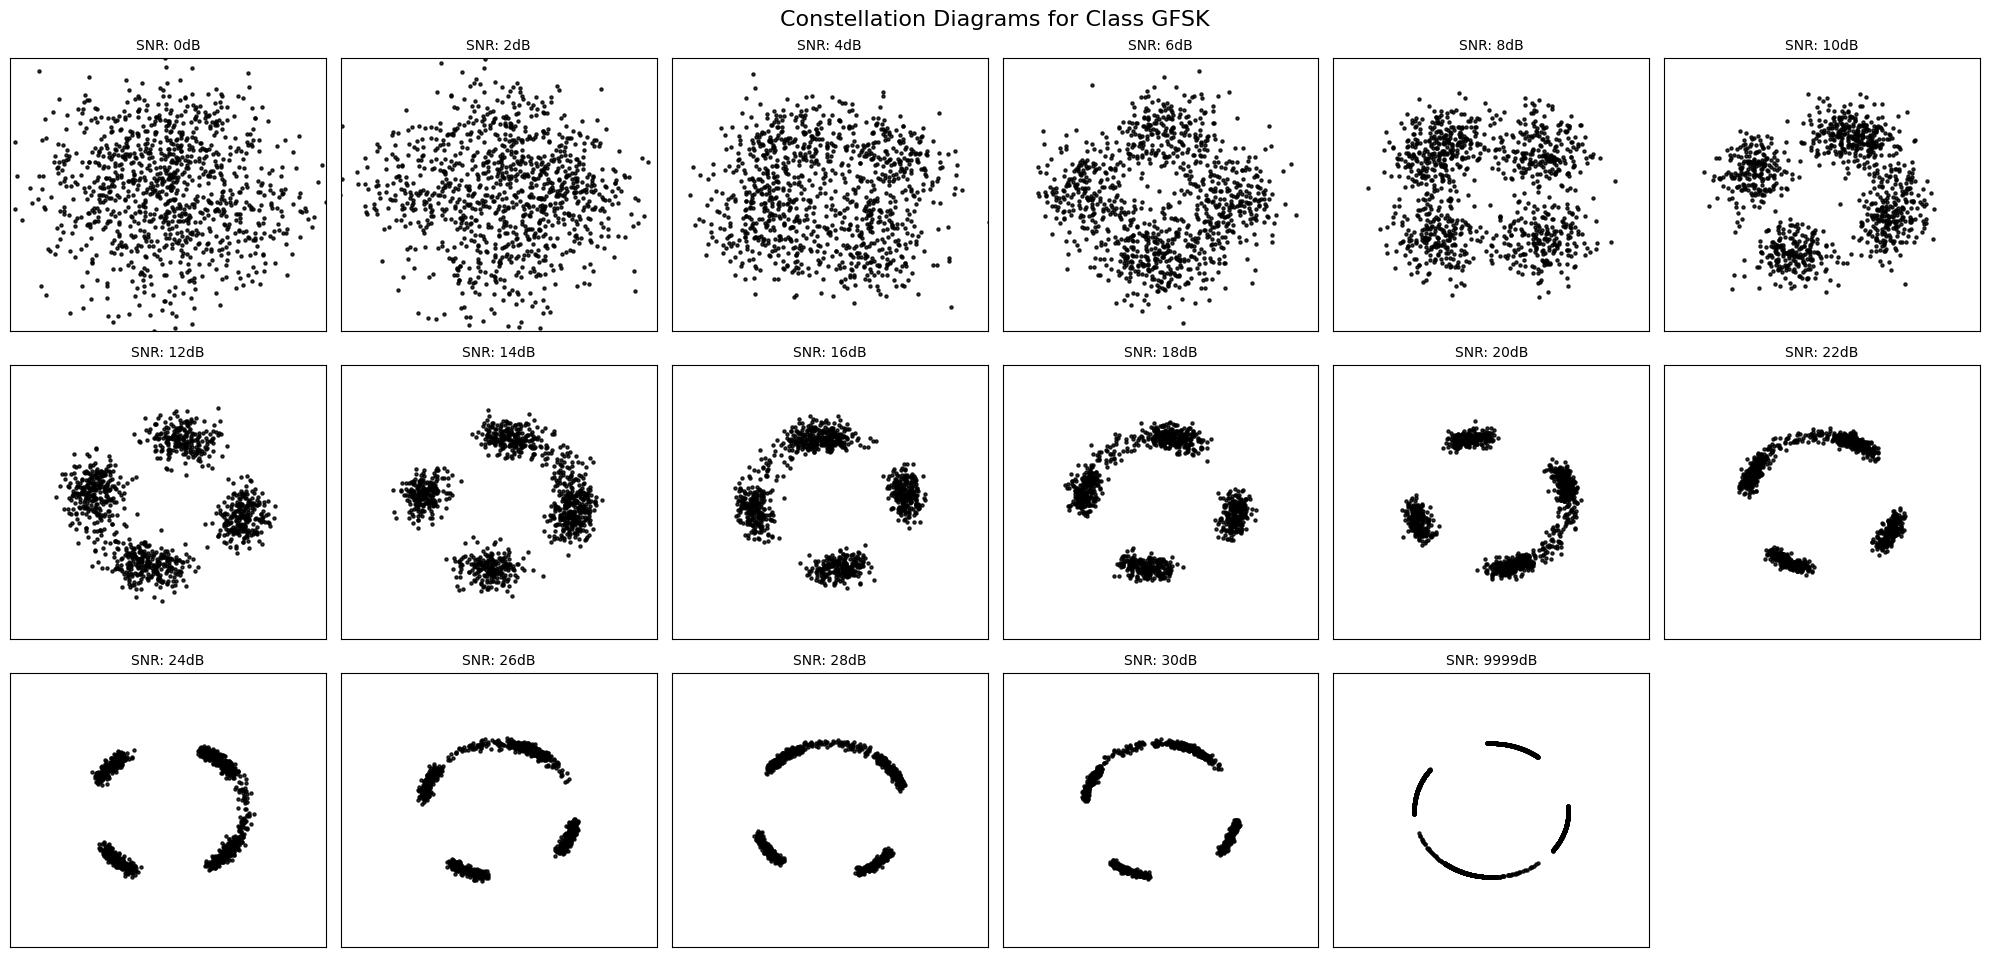

In [5]:
snr_values = np.append(np.arange(0, 32, 2), 9999)
# Plot constellation diagrams for the extracted dataset
def plot_constellation_snr_levels(modulation_class_index, extracted_classes, X, Y, Z):
        # Get modulation class name from extracted_classes
        class_name = extracted_classes[modulation_class_index]

        # Find indices of the target modulation class
        selected_class_indices = np.where(Y == modulation_class_index)[0]

        # Get unique SNR levels
        snr_values = np.unique(Z)

        # Plot constellation diagrams for all SNR levels
        plt.figure(figsize=(20, 16))
        for i, snr in enumerate(snr_values):
            # Find indices corresponding to the current SNR level
            snr_indices = selected_class_indices[np.where(Z[selected_class_indices] == snr)[0]]

            if len(snr_indices) == 0:
                continue

            # Extract the first sample for the current SNR level
            iq_samples = X[snr_indices]
            # print(iq_samples.shape)
            # break
            # Separate into in-phase (I) and quadrature (Q) components
            I = iq_samples[90, :, 0].flatten()
            Q = iq_samples[90, :, 1].flatten()

            # Plot the scatter plot
            ax = plt.subplot(5, 6, i + 1)
            ax.scatter(I, Q, s=5, alpha=0.8, color='black')
            ax.set_title(f"SNR: {snr}dB", fontsize=10)
            ax.set_xlim([-0.002, 0.002])  # Set uniform x-axis limits
            ax.set_ylim([-0.002, 0.002])  # Set uniform y-axis limits
            ax.set_xticks([])  # Set x-axis ticks
            ax.set_yticks([])  # Set y-axis ticks
            ax.grid(True, linestyle='--', alpha=0.6)


        plt.suptitle(f"Constellation Diagrams for Class {class_name}", fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.95)
        plt.show()


# Paths to extracted dataset and relevant parameters
classes = [
    'BPSK', 'QPSK', '8PSK', '16QAM', '64QAM', 'AM-DSB-SC', 'AM-SSB-SC', 'FM', 'GMSK', 'GFSK'
]

for modulation_class_index in range(10):
    plot_constellation_snr_levels(modulation_class_index, classes, X, Y, Z)

## **Normalization**
- Normalizes the IQ samples to -1 to 1 range.
- Normalization is essential for faster convergence during training.

In [6]:
epsilon = 1e-8  # A small value to avoid division by zero
X_min = np.min(X, axis=1, keepdims=True)
X_max = np.max(X, axis=1, keepdims=True)

# Compute range
X_range = X_max - X_min

# Create a mask where range is 0
mask = X_range == 0

# Normalize to [-1, 1] (Avoid division by zero by adding epsilon)
X = np.where(mask, 0, 2 * (X - X_min) / (X_range + epsilon) - 1)

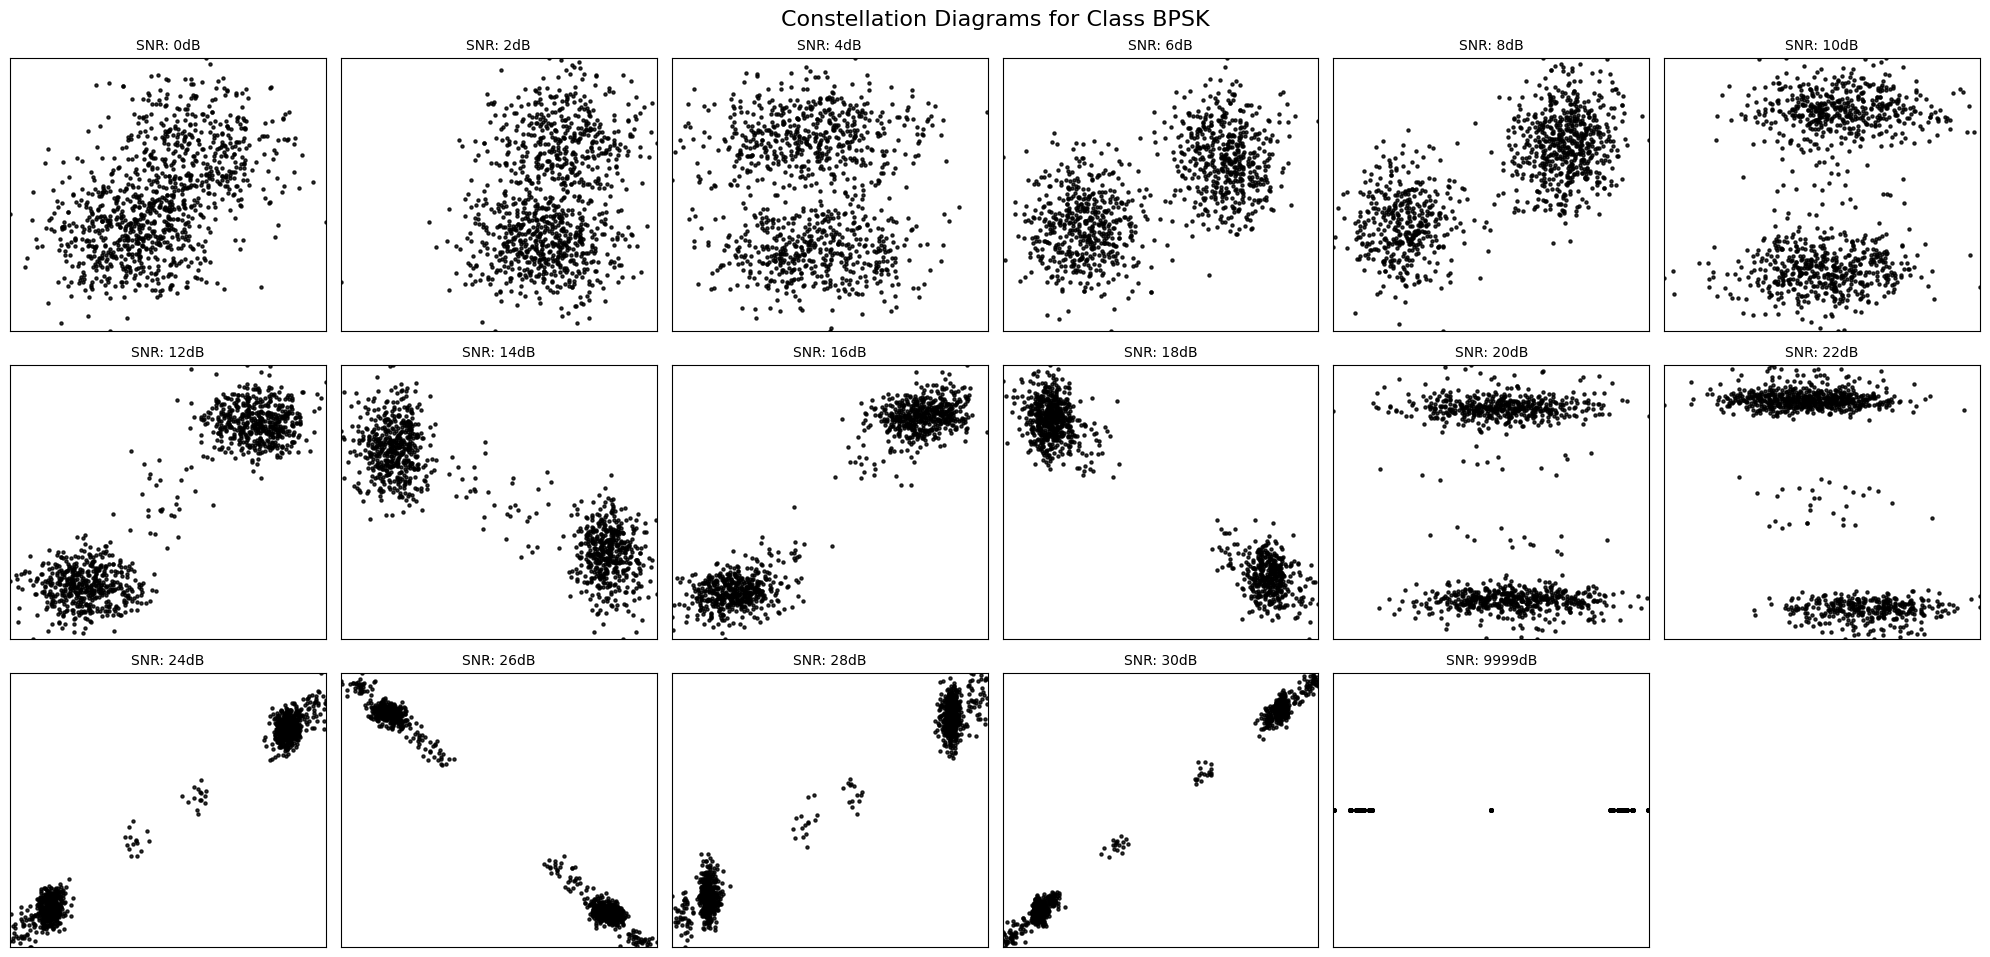

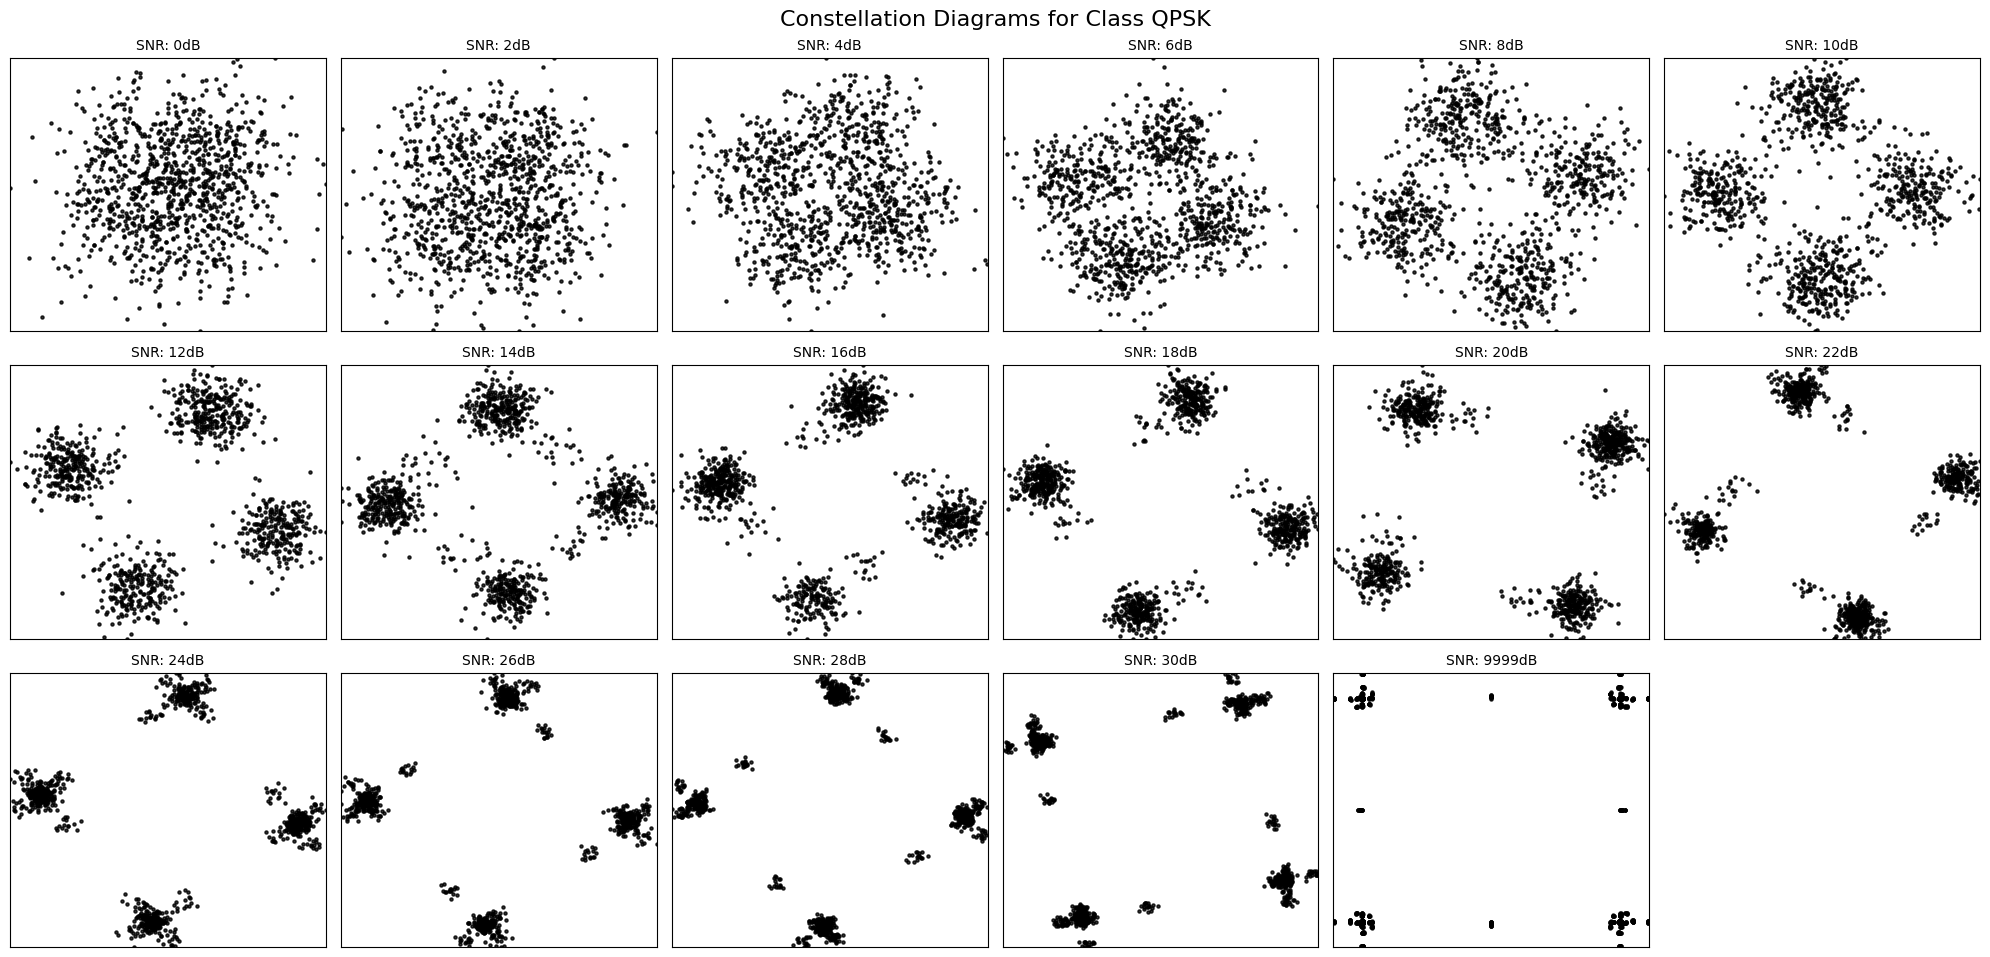

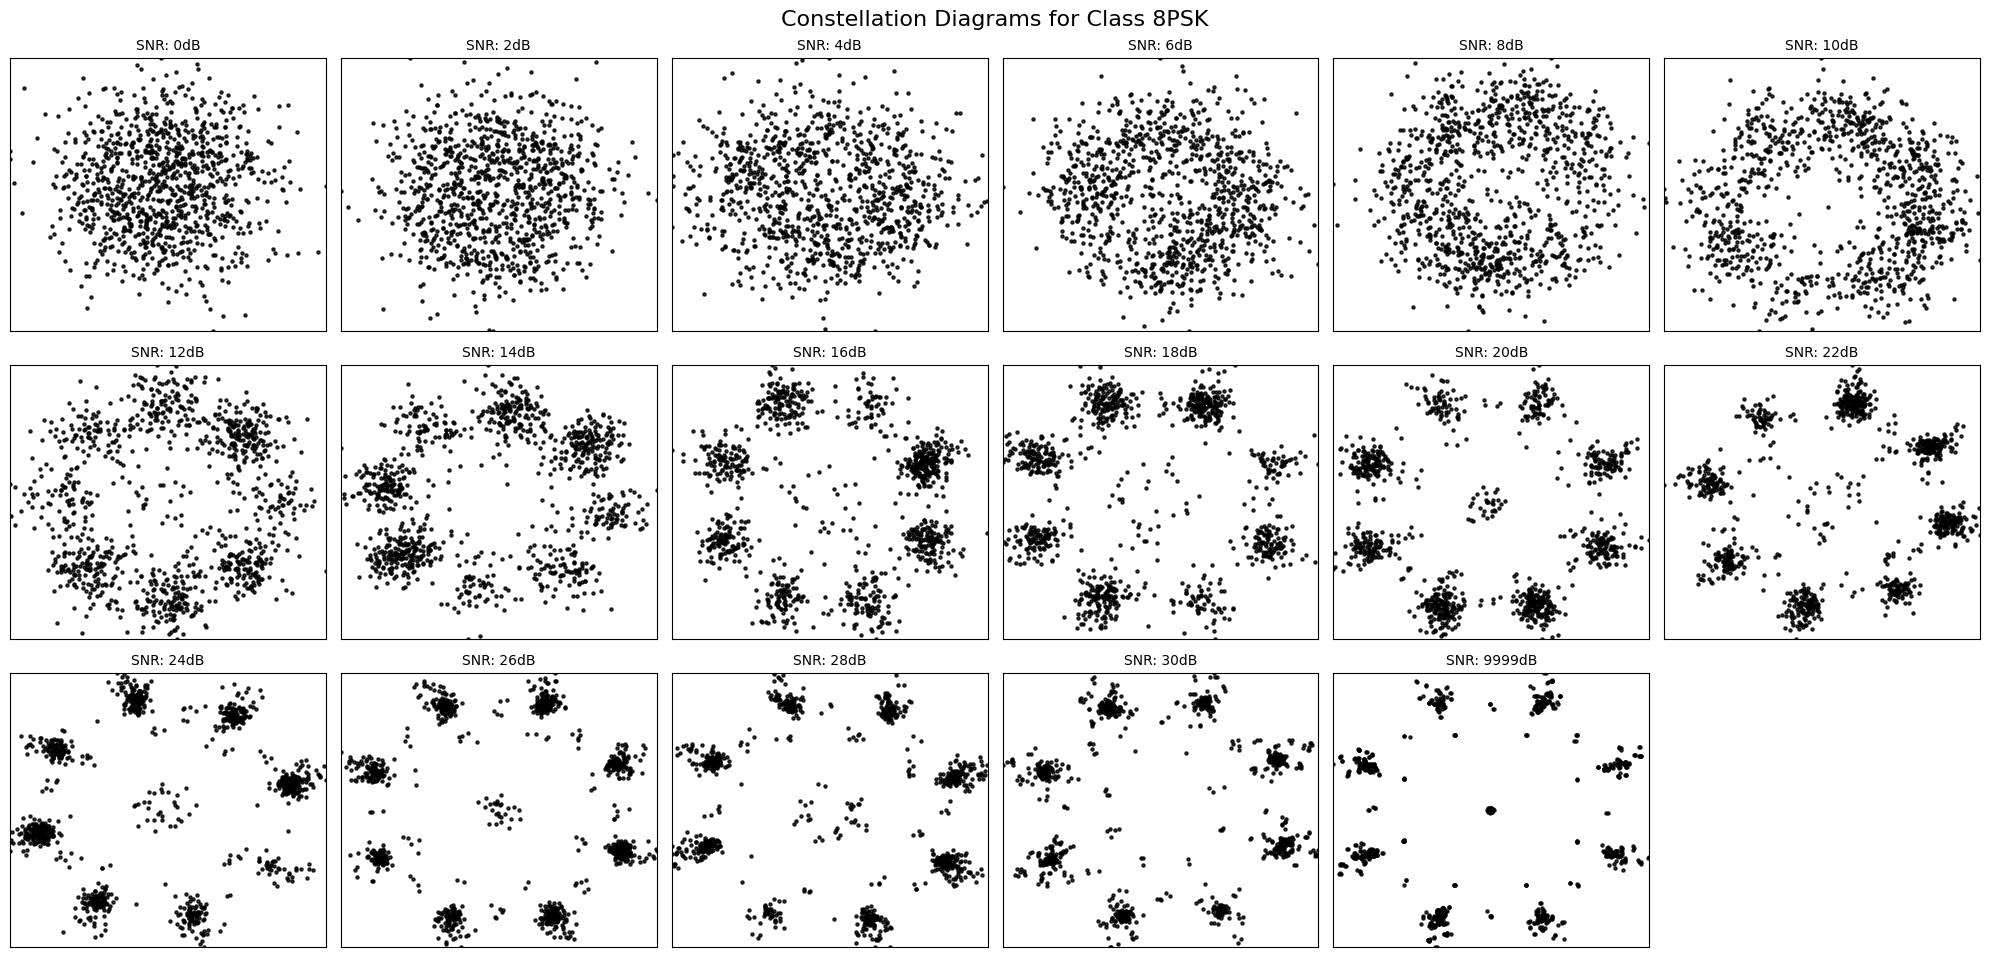

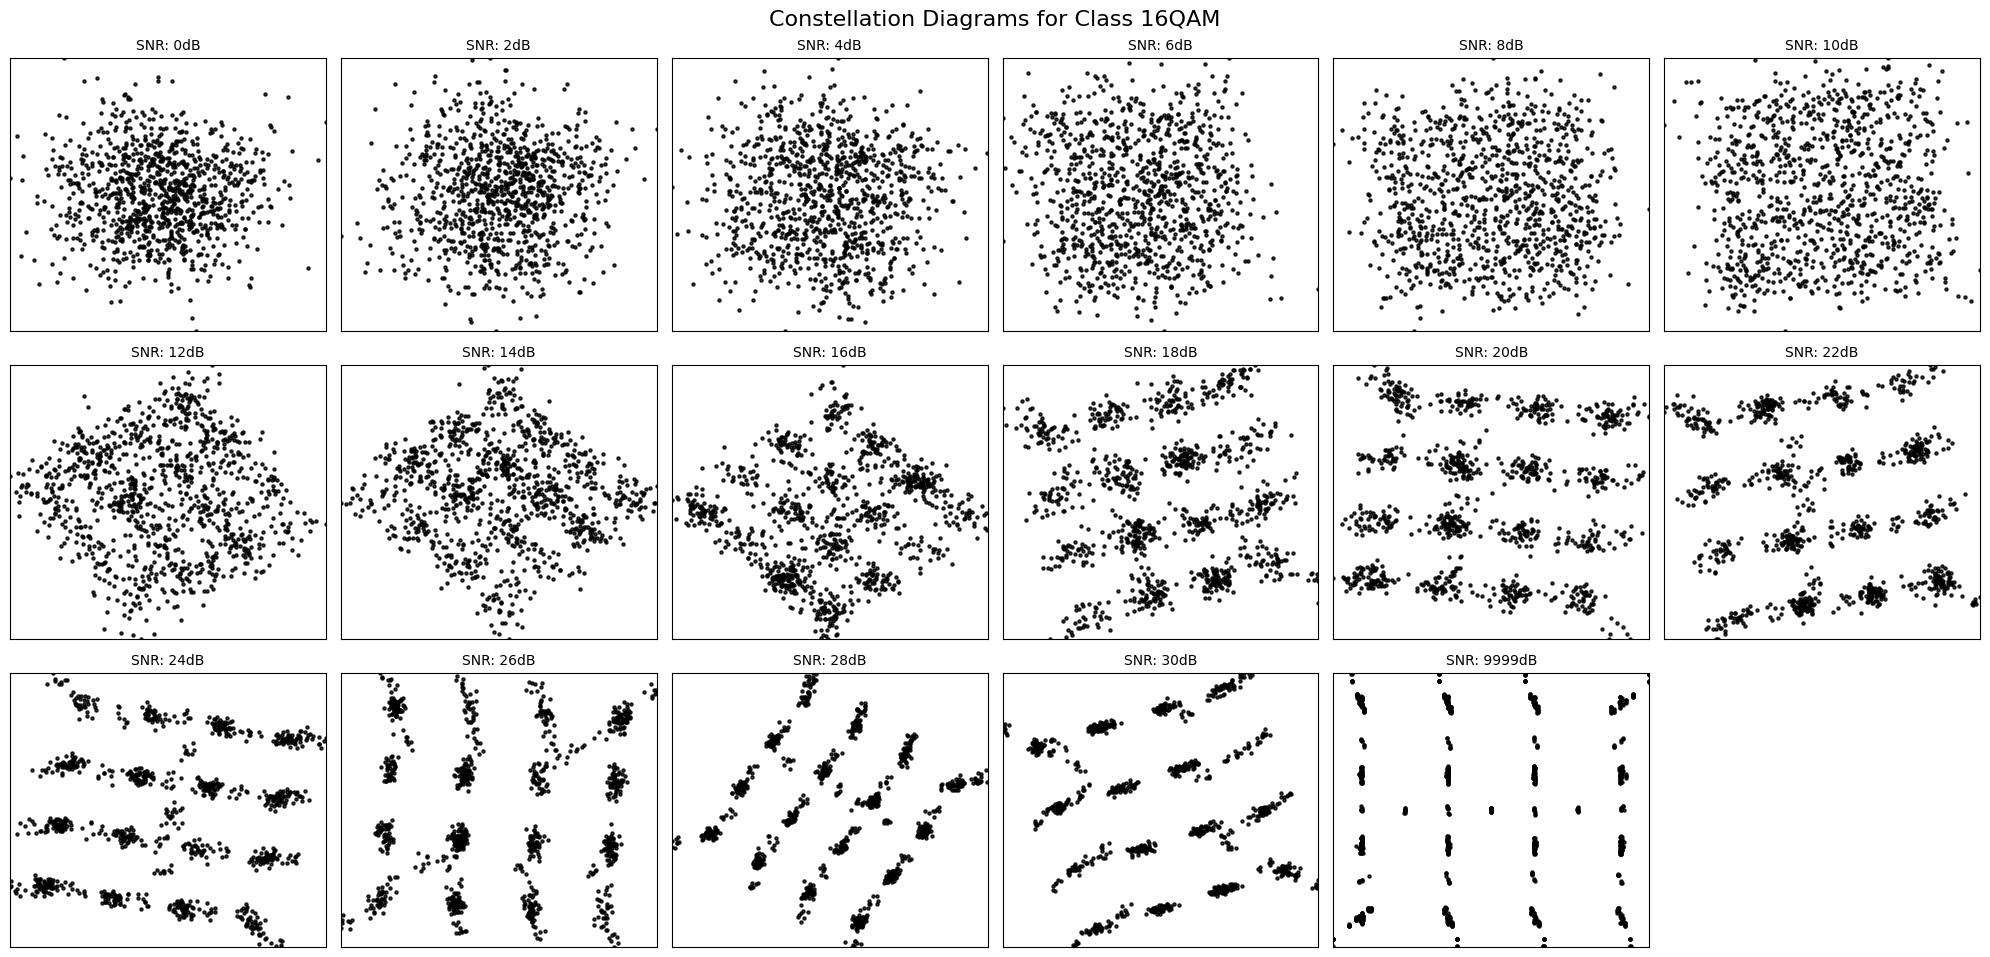

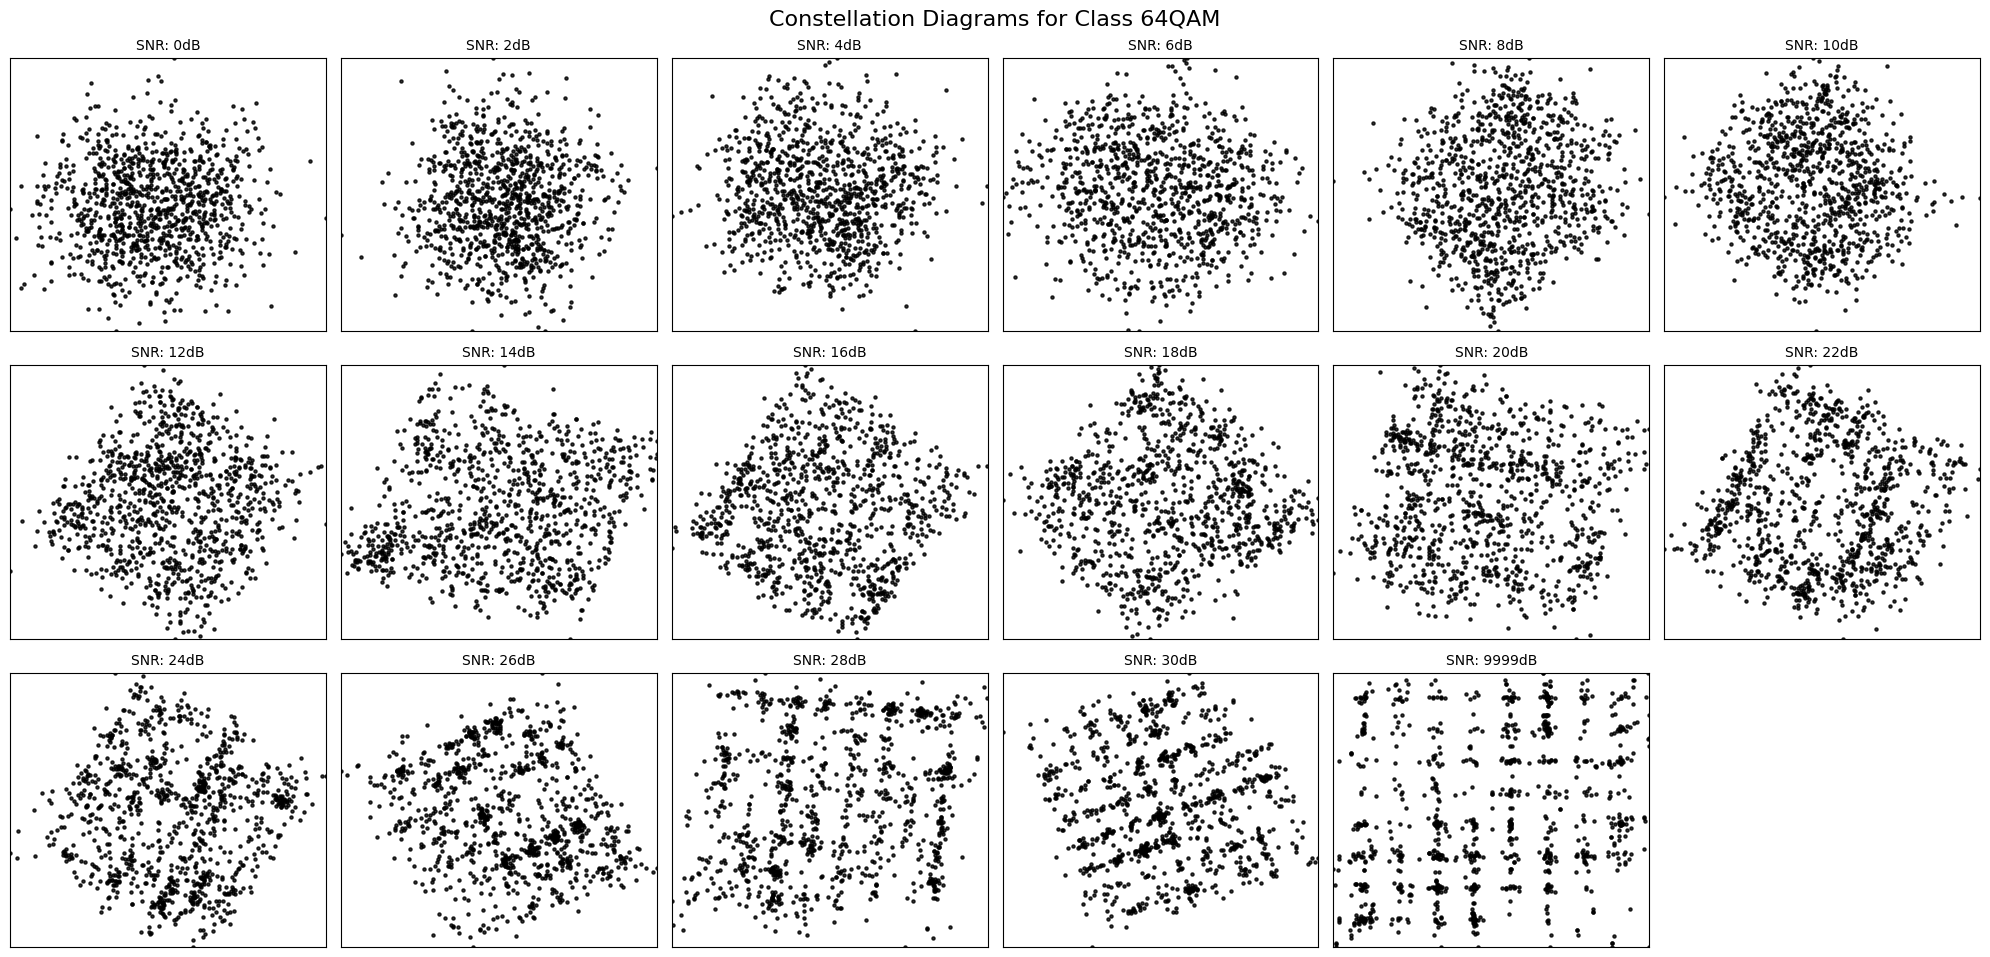

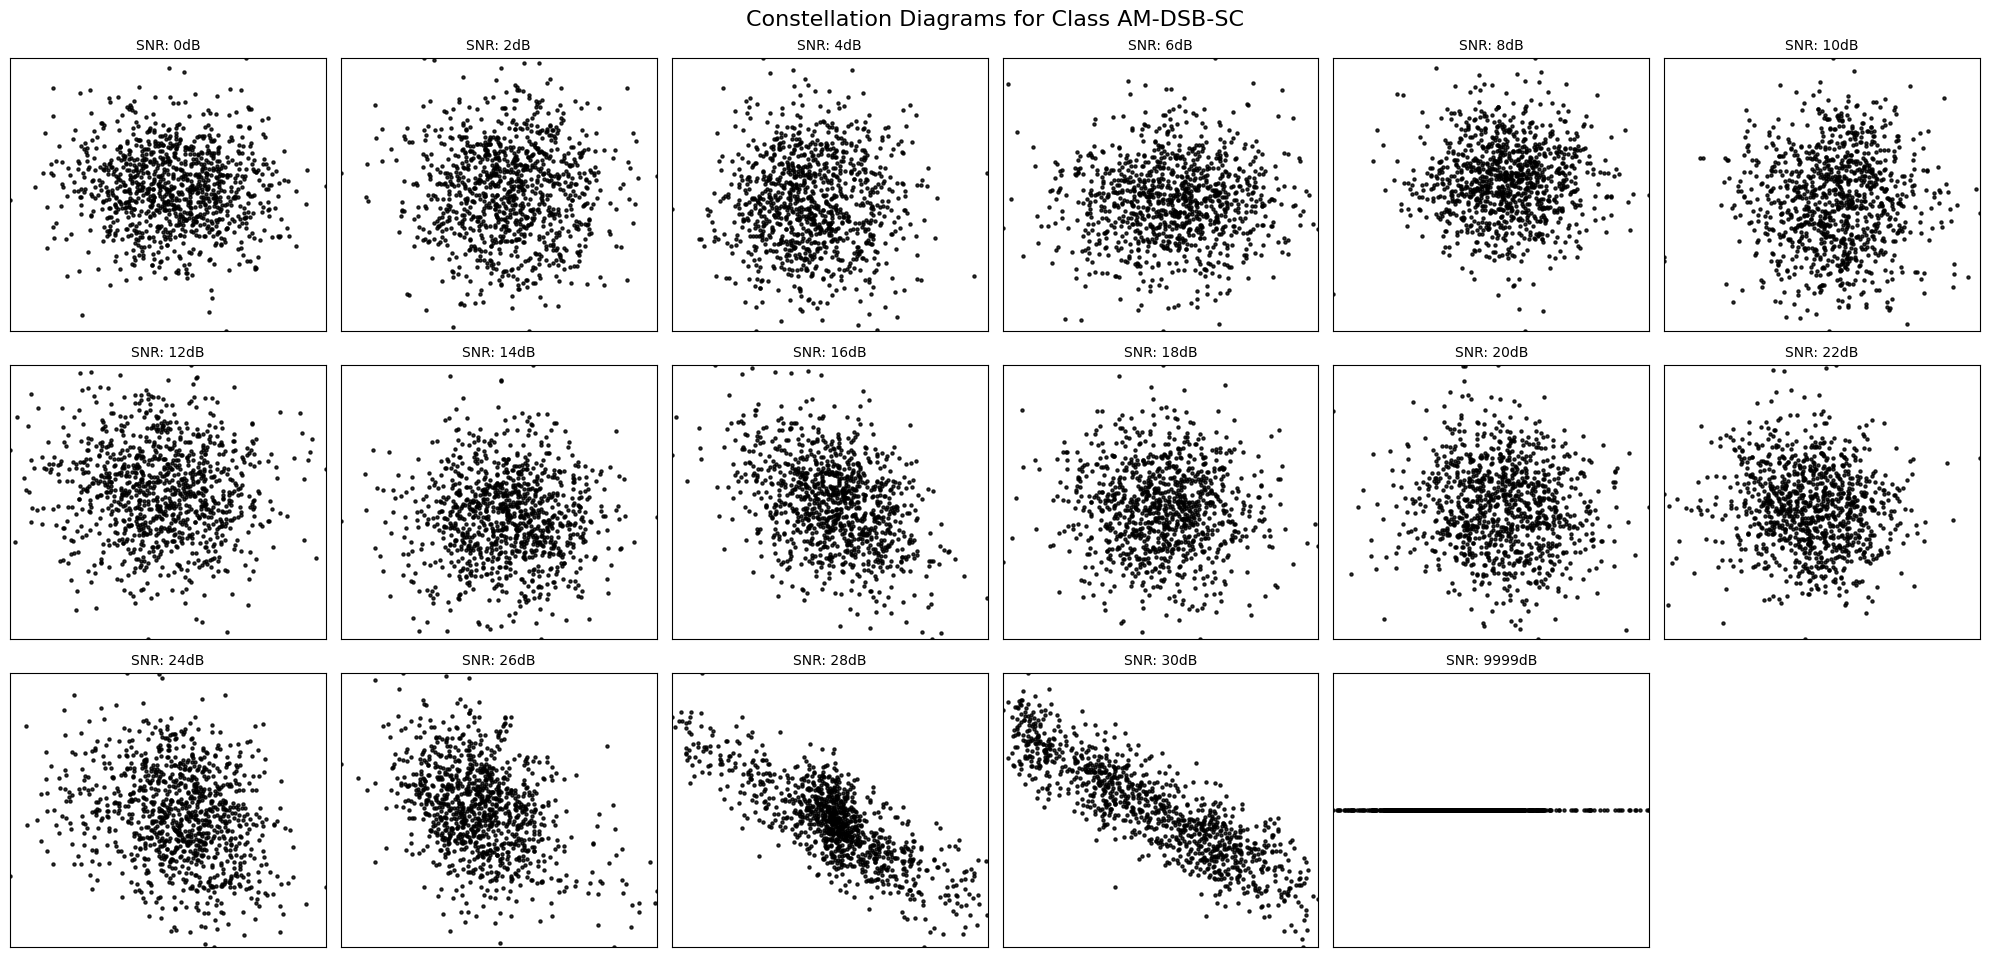

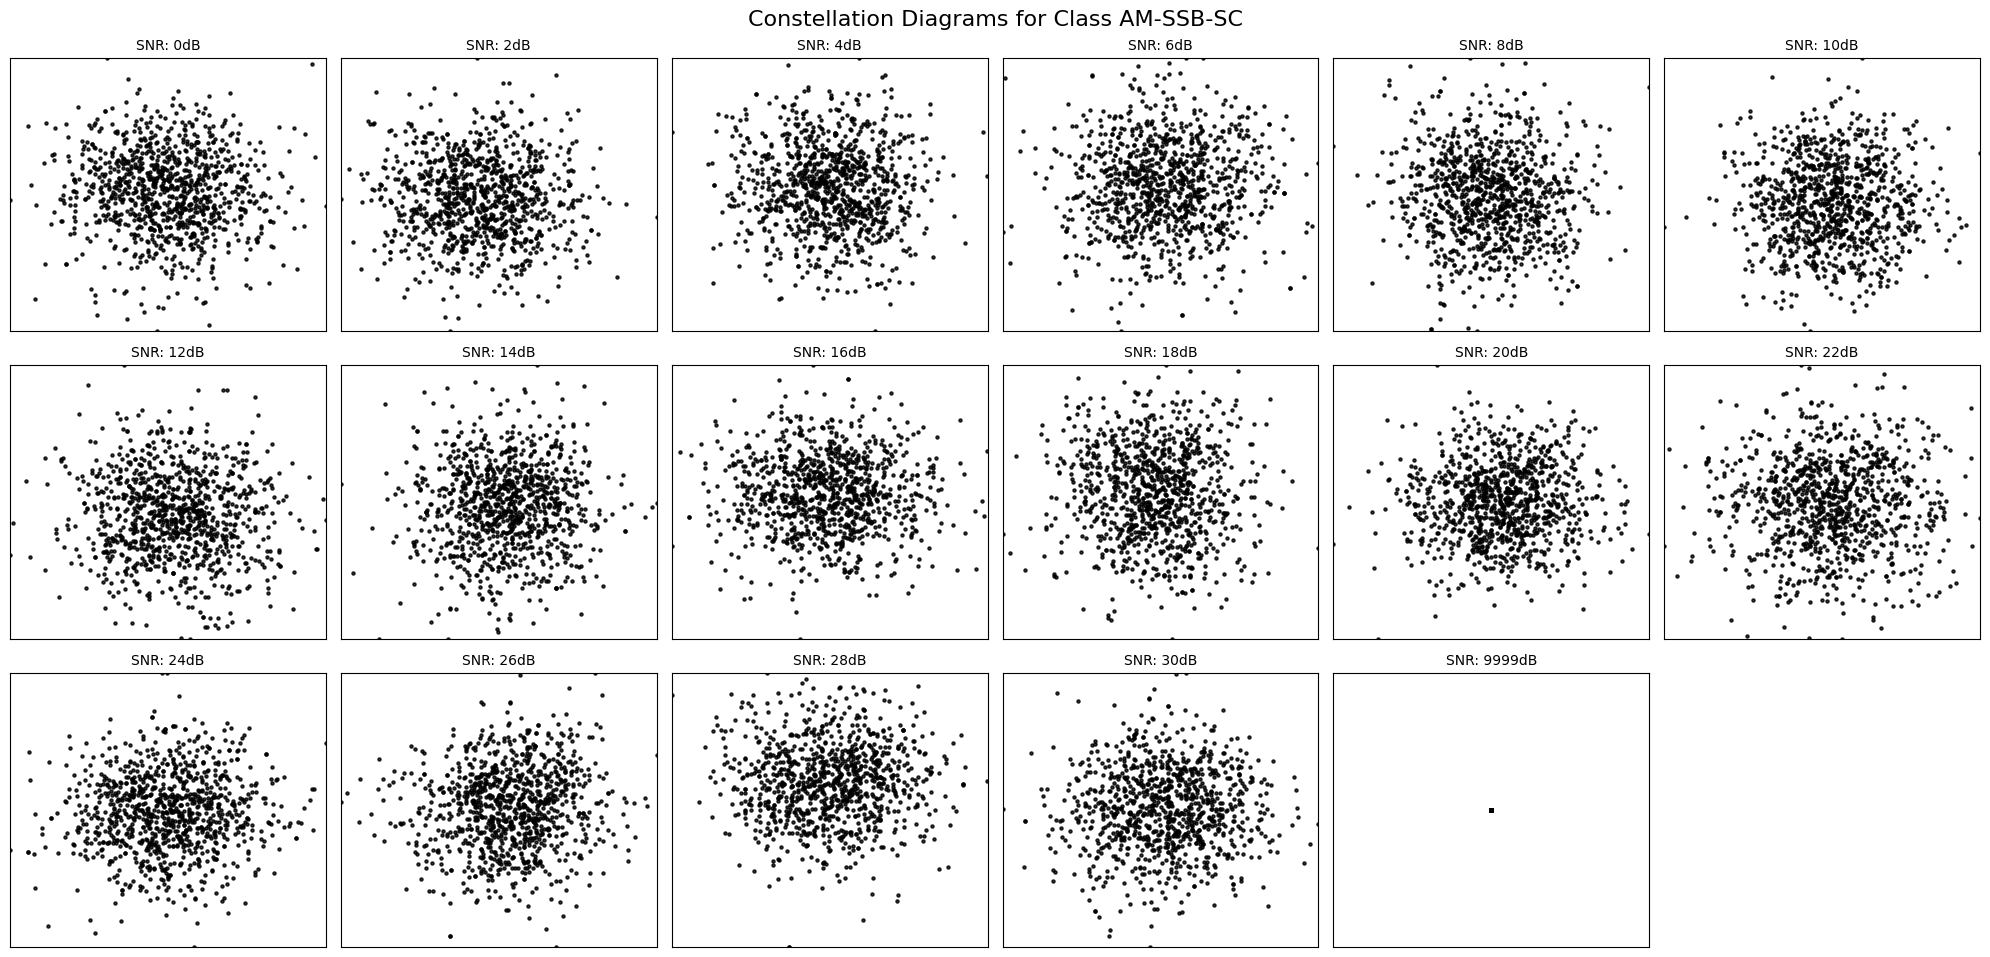

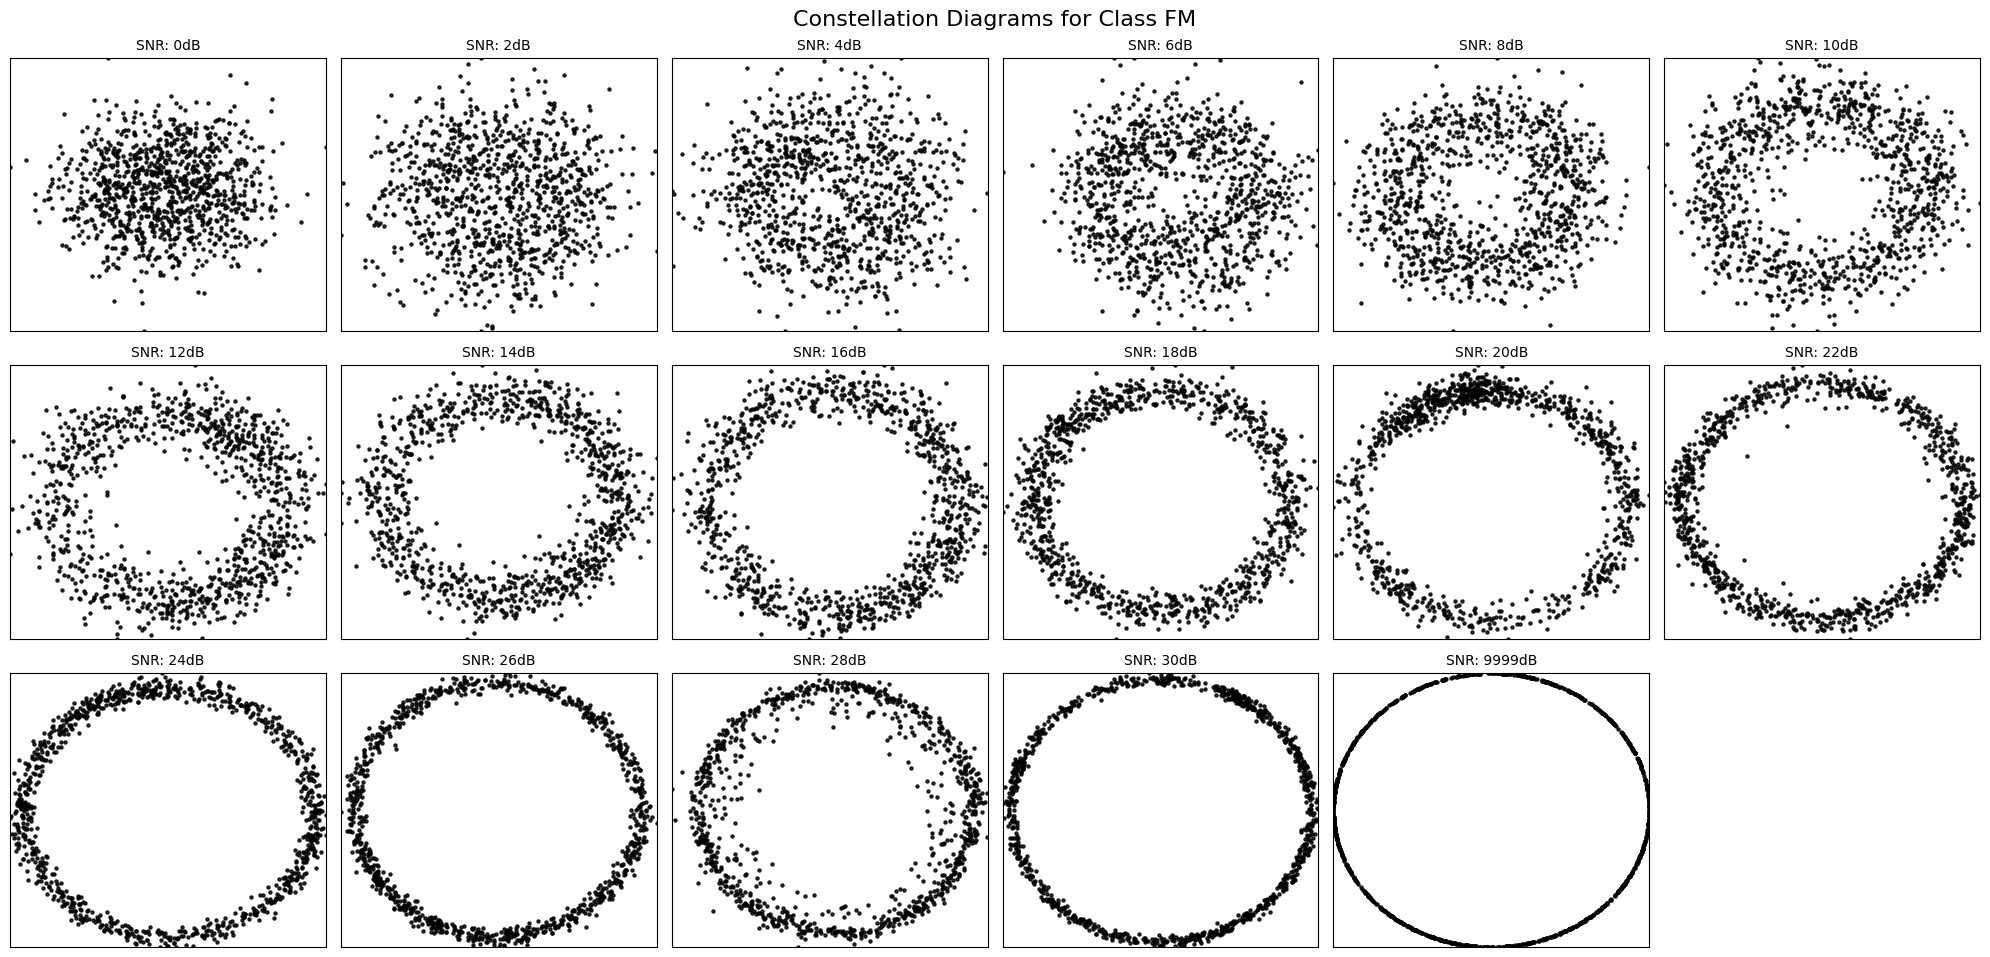

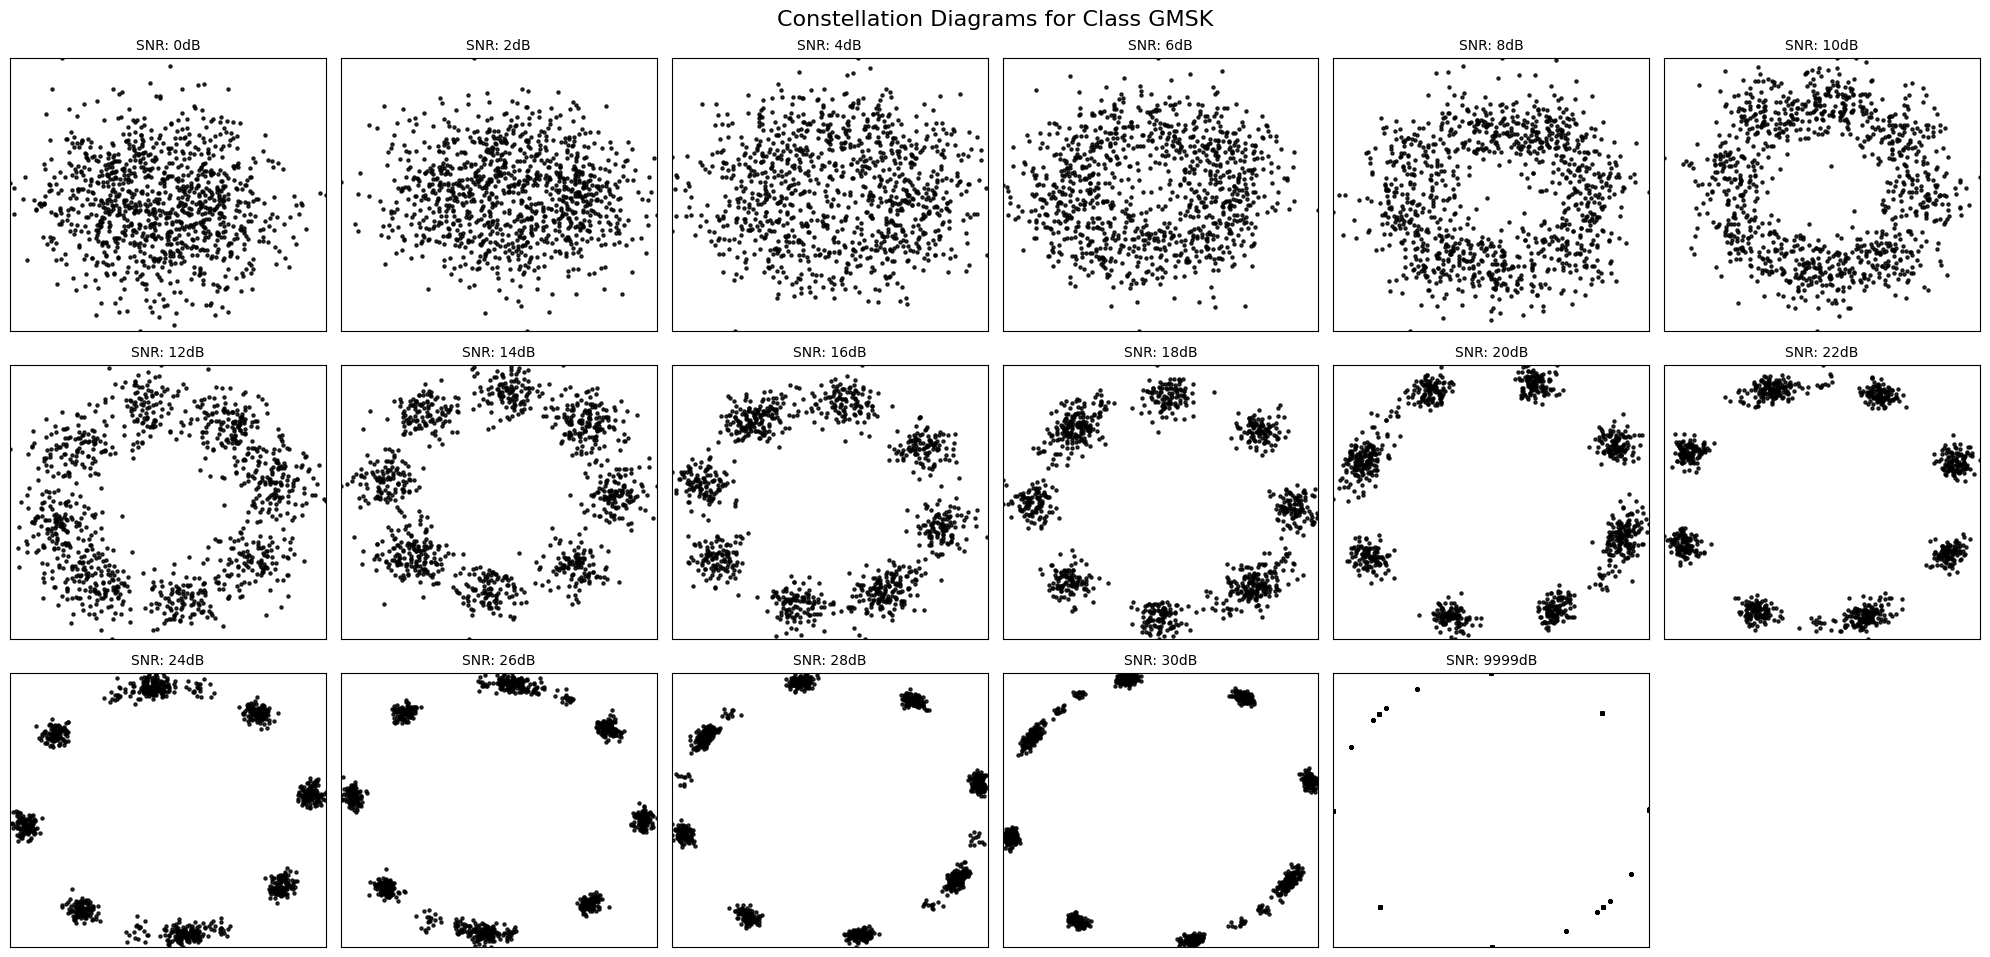

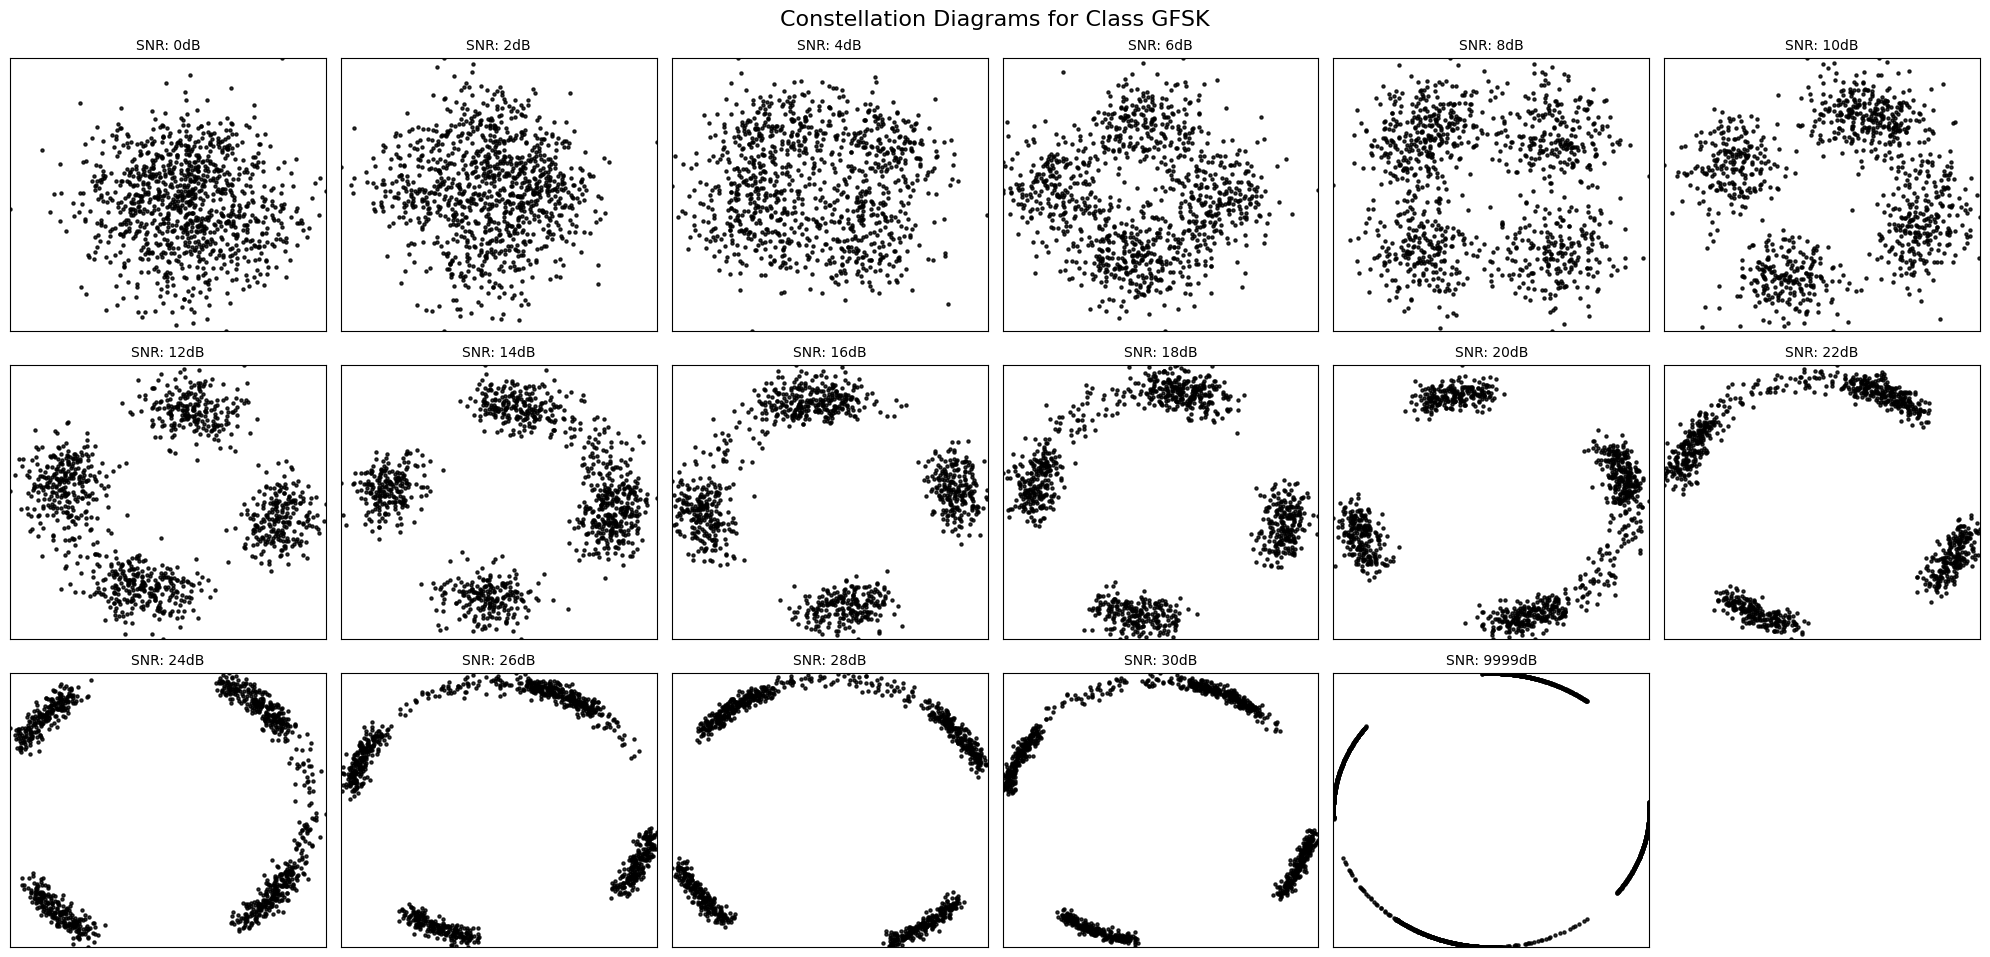

In [7]:
snr_values = np.append(np.arange(0, 32, 2), 9999)
# Plot constellation diagrams for the extracted dataset
def plot_constellation_snr_levels(modulation_class_index, extracted_classes, X, Y, Z):
        # Get modulation class name from extracted_classes
        class_name = extracted_classes[modulation_class_index]

        # Find indices of the target modulation class
        selected_class_indices = np.where(Y == modulation_class_index)[0]

        # Get unique SNR levels
        snr_values = np.unique(Z)

        # Plot constellation diagrams for all SNR levels
        plt.figure(figsize=(20, 16))
        for i, snr in enumerate(snr_values):
            # Find indices corresponding to the current SNR level
            snr_indices = selected_class_indices[np.where(Z[selected_class_indices] == snr)[0]]

            if len(snr_indices) == 0:
                continue

            # Extract the first sample for the current SNR level
            iq_samples = X[snr_indices]
            # print(iq_samples.shape)
            # break
            # Separate into in-phase (I) and quadrature (Q) components
            I = iq_samples[90, :, 0].flatten()
            Q = iq_samples[90, :, 1].flatten()

            # Plot the scatter plot
            ax = plt.subplot(5, 6, i + 1)
            ax.scatter(I, Q, s=5, alpha=0.8, color='black')
            ax.set_title(f"SNR: {snr}dB", fontsize=10)
            ax.set_xlim([-1, 1])  # Set uniform x-axis limits
            ax.set_ylim([-1, 1])  # Set uniform y-axis limits
            ax.set_xticks([])  # Set x-axis ticks
            ax.set_yticks([])  # Set y-axis ticks
            ax.grid(True, linestyle='--', alpha=0.6)


        plt.suptitle(f"Constellation Diagrams for Class {class_name}", fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.95)
        plt.show()


# Paths to extracted dataset and relevant parameters
classes = [
    'BPSK', 'QPSK', '8PSK', '16QAM', '64QAM', 'AM-DSB-SC', 'AM-SSB-SC', 'FM', 'GMSK', 'GFSK'
]

for modulation_class_index in range(10):
    plot_constellation_snr_levels(modulation_class_index, classes, X, Y, Z)

## **Train-Test Split**
- Splits the dataset into training and testing sets.
- The training set contains 80% of the data, while the testing set  & validation set contains 20% of the data.

In [8]:
from sklearn.model_selection import train_test_split


# # snr_levels = [9999]
snr_levels = np.append(np.arange(0, 32, 2), 9999)
modulation_schemes = range(10)

test_size = 0.1
valid_size = 0.1

train_indices = []
validation_indices = []
test_indices = []

for modulation_scheme in modulation_schemes:
    indices = np.where(Y == modulation_scheme)[0]
    # now for these indices find each SNR indices in snr_levels
    for snr in snr_levels:
        snr_indices = np.where(Z[indices] == snr)[0]

        # split into train+valid and test first
        train_valid, test = train_test_split(
            snr_indices, test_size=test_size, stratify=Z[indices][snr_indices], random_state=42
        )

        # further split train_valid into train and validation sets
        train, valid = train_test_split(
            train_valid, test_size=valid_size / (1 - test_size), stratify=Z[indices][train_valid], random_state=42
        )

        train_indices.extend(indices[train])
        validation_indices.extend(indices[valid])
        test_indices.extend(indices[test])

# convert lists to numpy arrays for shuffling
train_indices = np.array(train_indices)
validation_indices = np.array(validation_indices)
test_indices = np.array(test_indices)

# shuffle the indices
np.random.shuffle(train_indices)
np.random.shuffle(validation_indices)
np.random.shuffle(test_indices)


print("Train size: ", len(train_indices))
print("Validation size: ", len(validation_indices))
print("Test size: ", len(test_indices))

print(train_indices[:10])
print(validation_indices[:10])
print(test_indices[:10])

Train size:  692920
Validation size:  86700
Test size:  86700
[283410 599911 696139 627719 370296 104291 861033 421562 246195 336827]
[326068 171828 270469 388807 638303 848275 480512 433453  23369  71936]
[859626   7904 102422 499319 431915 304430  46879 590429 145313 812346]


## **Data Preparation**
- Windows the IQ samples into smaller segments.
- Converts into 224x224x3 images by stacking the IQ, amplitude, and phase components.
- Splits the data into batches and converts them into PyTorch tensors.

In [9]:
def windowing_function(input_data):

    if input_data.shape != (1024, 2):
        raise ValueError("Input data must have shape (1024, 2).")

    window_size = 224
    overlap = window_size // 2
    step_size = window_size - overlap
    output_sequences = []

    for i in range(0, 1024 - window_size, step_size):
        output_sequences.append(input_data[i:i + window_size])

    return np.array(output_sequences)

In [10]:
def process_indices(indices):
    X_seq = []
    Y_seq = []

    for idx in indices:
        seq = windowing_function(X[idx])
        X_seq.append(seq)
        Y_seq.append(np.full(len(seq), Y[idx], dtype=np.float16))

    return np.concatenate(X_seq, axis=0, dtype=np.float16), np.concatenate(Y_seq, axis=0)

# Process training, validation, and test sets
X_train, Y_train = process_indices(train_indices)
X_valid, Y_valid = process_indices(validation_indices)
# X_test, Y_test = process_indices(test_indices)

In [11]:
def amplitude_phase_seq_batch(iq_seq, device):
    if isinstance(iq_seq, np.ndarray):
        iq_seq = torch.from_numpy(iq_seq).to(device, dtype=torch.float32)
    else:
        iq_seq = iq_seq.to(device, dtype=torch.float32)
    squared = iq_seq ** 2
    amplitude = torch.sqrt(torch.sum(squared, dim=2, keepdim=True))
    phase = torch.atan2(iq_seq[..., 1], iq_seq[..., 0]).unsqueeze(-1)
    return torch.cat((iq_seq, amplitude, phase), dim=2)

In [12]:
import gc
del X, Y, Z
gc.collect()

67451

In [13]:
def data_preparation_alexnet(input_data, device):
    iq_channel = input_data[:, :, :2] # Shape: (32, 224, 2)
    amp_channel = input_data[:, :, 2:3]  # Shape: (32, 224, 1)
    phase_channel = input_data[:, :, 3:]  # Shape: (32, 224, 1)

    # print(iq_channel.shape)
    iq_channel = iq_channel.repeat(1, 1, 112)
    amp_channel = amp_channel.repeat(1, 1, 224)
    phase_channel = phase_channel.repeat(1, 1, 224)

    # adding new dimension for channel to make the shape (8, 3, 224, 224)
    input_tensor = torch.stack([iq_channel, amp_channel, phase_channel], dim=1)

    input_tensor = input_tensor.to(device)
    return input_tensor

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

class AlexNetModified(nn.Module):
    def __init__(self):
        super(AlexNetModified, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.features(x)
        x = self.global_avg_pooling(x)
        # x = torch.flatten(x, 1)
        return x


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size,
                            num_layers, batch_first=True)
        # self.fc1 = nn.Linear(hidden_size * 8, 512)
        # self.fc2 = nn.Linear(512, 256)
        # self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(
            0), self.hidden_size, device=x.device).detach()
        c0 = torch.zeros(self.num_layers, x.size(
            0), self.hidden_size, device=x.device).detach()
        out, _ = self.lstm(x, (h0, c0))
        out = out.reshape(out.size(0), -1)  # Flatten all hidden states
        # out = F.relu(self.fc1(out))
        # out = F.relu(self.fc2(out))
        # out = self.fc3(out)
        return out


class FullyConnectedLayer(nn.Module):
    def __init__(self, input_size, drop_factor, output_size):
        super(FullyConnectedLayer, self).__init__()
        self.l1 = nn.Linear(input_size, 512)
        self.dropout1 = nn.Dropout(drop_factor)
        self.l2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(drop_factor)
        self.l3 = nn.Linear(256, output_size)

    def forward(self, x):
        x = F.leaky_relu(self.l1(x))
        x = self.dropout1(x)
        x = F.leaky_relu(self.l2(x))
        x = self.dropout2(x)
        x = self.l3(x)
        return x

Device:  cuda


In [15]:
params = {
    "input_size": 256,
    "hidden_size": 256,
    "num_layers": 2,
    "num_classes": 10,
    "num_epochs": 10,
    "batch_size": 32,
    "num_seq": 8,
    "log_interval": 10,
    "hidden_layer1": 512,
    "hidden_layer2": 256,
    "dropout_factor": 0.6,
    "learning_rate": 0.00015
}

In [16]:
import gc
gc.collect()

0

In [17]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
Y_train = torch.tensor(Y_train, dtype=torch.float32).to(device)

# X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
# Y_test = torch.tensor(Y_test, dtype=torch.float32).to(device)

X_valid = torch.tensor(X_valid, dtype=torch.float32).to(device)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32).to(device)

In [18]:
class CustomDataloader(DataLoader):
    def __init__(self, dataset, batch_size, num_seq, shuffle=True):
        self.X = dataset.tensors[0]  # Input data
        self.Y = dataset.tensors[1]  # Labels
        self.batch_size = batch_size*num_seq
        self.num_seq = num_seq
        self.shuffle = shuffle
        self.indices = np.arange(len(self.X))
        if self.shuffle:
            np.random.shuffle(self.indices)


    def __iter__(self):
        self.i = 0
        return self

    def __next__(self):
        if self.i >= len(self.X):
            raise StopIteration

        # Get indices for the batch
        indices = self.indices[self.i:self.i + self.batch_size]
        self.i += self.batch_size

        batch_X = []
        batch_Y = []

        for index in indices:
            seq = self.X[index]  # Get the sequence data
            batch_X.append(seq)

            # Only add corresponding labels for the sequences indexed by multiple of `num_seq`
            if index % self.num_seq == 0:
                batch_Y.append(self.Y[index])

        # Stack the sequences into one tensor for X and Y
        # Shape: [batch_size, seq_len, 224, 4]
        batch_X_tensor = torch.stack(batch_X)
        # Shape: [batch_size // num_seq, label_dim]
        batch_Y_tensor = torch.stack(batch_Y)

        # Move tensors to the correct device
        return batch_X_tensor.to(device), batch_Y_tensor.to(device)

    def __len__(self):
        return len(self.X) // self.batch_size


train_data = TensorDataset(X_train, Y_train)
train_dataloader = CustomDataloader(train_data, batch_size=params["batch_size"], shuffle=False, num_seq= params["num_seq"])

valid_data = TensorDataset(X_valid, Y_valid)
valid_dataloader = CustomDataloader(
    valid_data, batch_size=params["batch_size"], shuffle=False, num_seq=params["num_seq"])


# test_data = TensorDataset(X_test, Y_test)
# test_dataloader = CustomDataloader(test_data, batch_size=params["batch_size"], shuffle=False, num_seq = params["num_seq"])

In [19]:
ALEX_model = AlexNetModified().to(device)

In [20]:
LSTM_model = LSTMModel(params["input_size"], params["hidden_size"], params["num_layers"]).to(device)

In [21]:
FC_model = FullyConnectedLayer(params["hidden_size"] * params["num_seq"], params["dropout_factor"], params["num_classes"]).to(device)

In [ ]:
import os
import time
import torch
import torch.nn as nn

log_interval = 10
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(ALEX_model.parameters()) +
                             list(LSTM_model.parameters()) +
                             list(FC_model.parameters()), lr=params["learning_rate"])

# Initialize history tracking variables
train_loss_history, val_loss_history = [], []
train_acc_history, val_acc_history = [], []

# Check for existing checkpoint
latest_checkpoint = None
if os.path.exists(checkpoint_dir):
    checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith("best_model_epoch_")]
    if checkpoint_files:
        checkpoint_files.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))  # Sort by epoch number
        latest_checkpoint = os.path.join(checkpoint_dir, checkpoint_files[-1])

if latest_checkpoint:
    checkpoint = torch.load(latest_checkpoint, weights_only=True)
    ALEX_model.load_state_dict(checkpoint['ALEX_model_state_dict'])
    LSTM_model.load_state_dict(checkpoint['LSTM_model_state_dict'])
    FC_model.load_state_dict(checkpoint['FC_model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    best_val_loss = checkpoint['loss']
    train_loss_history = checkpoint.get('train_loss_history', [])
    val_loss_history = checkpoint.get('val_loss_history', [])
    train_acc_history = checkpoint.get('train_acc_history', [])
    val_acc_history = checkpoint.get('val_acc_history', [])
    print(f"Resuming training from epoch {start_epoch} with best validation loss {best_val_loss:.4f}")
else:
    start_epoch = 0
    best_val_loss = float('inf')
    print("No checkpoint found. Starting training from scratch.")

# Main training loop
for epoch in range(start_epoch, params["num_epochs"]):
    ALEX_model.train()
    LSTM_model.train()
    FC_model.train()

    running_loss, correct_train, total_train = 0.0, 0, 0
    start_time = time.time()

    for batch_idx, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = amplitude_phase_seq_batch(inputs, device)
        
        alexnet_input = data_preparation_alexnet(inputs, device)
        alex_output = ALEX_model(alexnet_input)
        lstm_input = alex_output.reshape(-1, params["num_seq"], 256)
        lstm_output = LSTM_model(lstm_input)
        fc_output = FC_model(lstm_output)

        loss = criterion(fc_output, labels.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predictions = torch.argmax(fc_output, dim=1)
        correct_train += (predictions == labels).sum().item()
        total_train += labels.size(0)

        if batch_idx % log_interval == 0:
            print(f"Epoch [{epoch+1}/{params['num_epochs']}], Batch [{batch_idx}/{len(train_dataloader)}], "
                  f"Loss: {loss.item():.4f}, Accuracy: {100 * correct_train / total_train:.2f}%")

    avg_train_loss = running_loss / len(train_dataloader)
    train_loss_history.append(avg_train_loss)
    avg_train_acc = 100 * correct_train / total_train
    train_acc_history.append(avg_train_acc)

    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_acc:.2f}%, "
          f"Time: {time.time() - start_time:.2f} seconds")

    # Validation phase
    ALEX_model.eval()
    LSTM_model.eval()
    FC_model.eval()

    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for val_inputs, val_labels in valid_dataloader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_inputs = amplitude_phase_seq_batch(val_inputs, device)
            
            alexnet_input = data_preparation_alexnet(val_inputs, device)
            alex_output = ALEX_model(alexnet_input)
            lstm_input = alex_output.reshape(-1, params["num_seq"], 256)
            lstm_output = LSTM_model(lstm_input)
            fc_output = FC_model(lstm_output)
            
            loss = criterion(fc_output, val_labels.long())
            val_loss += loss.item()
            predictions = torch.argmax(fc_output, dim=1)
            correct_val += (predictions == val_labels).sum().item()
            total_val += val_labels.size(0)

    avg_val_loss = val_loss / len(valid_dataloader)
    val_loss_history.append(avg_val_loss)
    avg_val_acc = 100 * correct_val / total_val
    val_acc_history.append(avg_val_acc)

    print(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {avg_val_acc:.2f}%")

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        checkpoint_path = os.path.join(checkpoint_dir, f'best_model_epoch_{epoch+1}.pth')
        torch.save({
            'epoch': epoch + 1,
            'ALEX_model_state_dict': ALEX_model.state_dict(),
            'LSTM_model_state_dict': LSTM_model.state_dict(),
            'FC_model_state_dict': FC_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_val_loss,
            'train_loss_history': train_loss_history,
            'val_loss_history': val_loss_history,
            'train_acc_history': train_acc_history,
            'val_acc_history': val_acc_history
        }, checkpoint_path)
        print(f"New best model saved at epoch {epoch+1}")

# Save final model
final_model_path = os.path.join(checkpoint_dir, 'final_model.pth')
torch.save({
    'ALEX_model_state_dict': ALEX_model.state_dict(),
    'LSTM_model_state_dict': LSTM_model.state_dict(),
    'FC_model_state_dict': FC_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': avg_val_loss,
    'train_loss_history': train_loss_history,
    'val_loss_history': val_loss_history,
    'train_acc_history': train_acc_history,
    'val_acc_history': val_acc_history
}, final_model_path)

print("Training complete. Final model saved.")

No checkpoint found. Starting training from scratch.
Epoch [1/10], Batch [0/21653], Loss: 2.3029, Accuracy: 9.38%
Epoch [1/10], Batch [10/21653], Loss: 2.3052, Accuracy: 9.09%
Epoch [1/10], Batch [20/21653], Loss: 2.3120, Accuracy: 10.27%
Epoch [1/10], Batch [30/21653], Loss: 2.3049, Accuracy: 10.79%
Epoch [1/10], Batch [40/21653], Loss: 2.2944, Accuracy: 10.98%
Epoch [1/10], Batch [50/21653], Loss: 2.1827, Accuracy: 11.52%
Epoch [1/10], Batch [60/21653], Loss: 2.0713, Accuracy: 13.01%
Epoch [1/10], Batch [70/21653], Loss: 2.0444, Accuracy: 13.86%
Epoch [1/10], Batch [80/21653], Loss: 1.9889, Accuracy: 14.27%
Epoch [1/10], Batch [90/21653], Loss: 2.0153, Accuracy: 14.42%
Epoch [1/10], Batch [100/21653], Loss: 2.0913, Accuracy: 14.39%
Epoch [1/10], Batch [110/21653], Loss: 1.8526, Accuracy: 14.61%
Epoch [1/10], Batch [120/21653], Loss: 1.7967, Accuracy: 14.70%
Epoch [1/10], Batch [130/21653], Loss: 1.9703, Accuracy: 15.08%
Epoch [1/10], Batch [140/21653], Loss: 1.8142, Accuracy: 15.34%


In [ ]:
np.save('./checkpoints/train_loss_history.npy', train_loss_history)
np.save('./checkpoints/val_loss_history.npy', val_loss_history)
np.save('./checkpoints/train_acc_history.npy', train_acc_history)
np.save('./checkpoints/val_acc_history.npy', val_acc_history)

In [ ]:
train_loss_history = np.load('./checkpoints/train_loss_history.npy')
val_loss_history = np.load('./checkpoints/val_loss_history.npy')

# Convert inf to NaN and drop them
train_loss_history = pd.Series(train_loss_history).replace([np.inf, -np.inf], np.nan).dropna().values
val_loss_history = pd.Series(val_loss_history).replace([np.inf, -np.inf], np.nan).dropna().values

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(len(train_loss_history)), y=train_loss_history, label='Train Loss')
sns.lineplot(x=range(len(val_loss_history)), y=val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

In [ ]:
torch.save(ALEX_model.state_dict(), './checkpoints/ALEX_model.pth')
torch.save(LSTM_model.state_dict(), './checkpoints/LSTM_model.pth')
torch.save(FC_model.state_dict(), './checkpoints/FC_model.pth')